# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date: Apr, 2018

## Situation:

A search session describes a user’s journey to find his ideal hotel, by including all his interactions. Given user search sessions, we are interested in predicting the outcome of these sessions based on the users’ interactions; as well determining which of these interactions have the highest importance for this estimation.

## Data:

We provide two kinds of data sets:

- anonymized user logs generated by usage on our website (user actions); and,
- booking outcome per session with contextual information (bookings).


Both types of datasets are split by the same timestamp into train and target sets. The target set contains the same information as the training set, except the outcome (i.e. has_booking). More information is provided in README.md (You can find this in the resources section).


## Task:

The task is to train a machine learning model to estimate if a booking occurred – the training and target sets have been provided for you. We expect binary predictions for the target sessions, which will be evaluated by Matthews Correlation Coefficient (MCC) using the ground truth dataset on our side. You can have as many submissions as you would like to improve your solution.


## Additional questions:

- What makes the classification problem difficult in this task? How do you handle that?
- Evaluate and compare at least 3 classification methods for this task.
- Propose at least 3 features that are significant to predict bookings?
- We can spot a very significant action type. What might this action refer to?



There are 3 types of data: Bookings, User actions, Example.

## Data: Bookings
- Description: List of sessions, each with: session-related contextual data, and whether at least one booking was made
- Files:
	- case_study_bookings_train.csv: Training sessions for bookings
	- case_study_bookings_target.csv: Target sessions to predict bookings
- Rows: Each row represents a session with session context and the outcome of this session
- Columns:
	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
    
## Data: User Actions
- Description: Sequence of various type of user actions generated during the usage of the website.
- Files
	- case_study_actions_train.csv: Training set of user actions
	- case_study_actions_target.csv: User actions in the target sessions
- Rows: Each row represents one action from/to the user
- Columns:
	- ymd: Date of the action in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- action_id: Type of the action
	- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
	- step: The number identifying the action in the session
	
## Data: Example Solution
- Description: List of predictions for bookings in the target sessions
- File: case_study_bookings_target_prediction_example.csv
- Rows: Each row represent a target session for which a prediction should be given
- Columns:
	- session_id: Anonymized id of the session
	- has_booking: Random binary predictions for bookings

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", DeprecationWarning)

import numpy as np
import pandas as pd
from datetime import datetime
import operator
from collections import OrderedDict
import time
import csv
import gc
from multiprocessing import Pool

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

import catboost
from catboost import CatBoostClassifier

np.random.seed(42)

In [11]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

## Step 1: read and explore the data

In [79]:
"""
train booking data
- ymd:           Date of the session in format 'yyMMdd'
- user_id:       Anonymized cookie id of the visitor
- session_id:    Anonymized id of the session
- referer_code:  Encoded category of the referer to the website
- is_app:        If the session was made using the trivago app
- agent_id:      Encoded type of the browser
- traffic_type:  A categorization of the type of the traffic
- has_booking:   1 if at least one booking was made during the session (excluded from the target set)
"""

train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

print('\ntrain booking')
print(train_booking_df.columns)
print(train_booking_df.describe())

print('\nmax')
print(train_booking_df.max())

print('\nmin')
print(train_booking_df.min())

display(train_booking_df.head(5))


train booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  3.076770e+05  3.076770e+05  307677.000000  307677.000000   
mean   4.622586e+18  4.609514e+18      22.857828       0.073571   
std    2.665868e+18  2.662771e+18      40.179017       0.261071   
min    3.883091e+14  1.097161e+14       0.000000       0.000000   
25%    2.312274e+18  2.303980e+18       0.000000       0.000000   
50%    4.635855e+18  4.612005e+18       1.000000       0.000000   
75%    6.932941e+18  6.912236e+18      15.000000       0.000000   
max    9.223267e+18  9.223359e+18      99.000000       1.000000   

            agent_id   traffic_type    has_booking  
count  307677.000000  307677.000000  307677.000000  
mean        7.424809       2.686174       0.063856  
std         3.713358       1.906000       0.244497  
min         0.000000       1.00

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0
2,2017-04-15,452426828488840,4191504489082712531,0,0,10,2,0
3,2017-04-06,819438352219100,4560227804862289210,1,0,1,1,0
4,2017-04-07,1113732603712480,4115013282086590434,0,0,9,2,0


In [80]:
"""
target booking data
- ymd:          Date of the session in format 'yyMMdd'
- user_id:      Anonymized cookie id of the visitor
- session_id:   Anonymized id of the session
- referer_code: Encoded category of the referer to the website
- is_app:       If the session was made using the trivago app
- agent_id:     Encoded type of the browser
- traffic_type: A categorization of the type of the traffic
"""

target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

print('\ntarget booking')
print(target_booking_df.columns)

print('\nmin')
print(target_booking_df.min())

print('\nmax')
print(target_booking_df.max())

display(target_booking_df.head(5))


target booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type'],
      dtype='object')

min
ymd             2017-04-28 00:00:00
user_id            1607565913119260
session_id          288684655403597
referer_code                      0
is_app                            0
agent_id                          0
traffic_type                      1
dtype: object

max
ymd             2017-04-30 00:00:00
user_id         9223057583881579293
session_id      9223351684048666531
referer_code                     99
is_app                            1
agent_id                         14
traffic_type                     10
dtype: object


,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6
1,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1
2,2017-04-30,2669945826129900,5361965966177226983,0,0,6,6
3,2017-04-30,6247954936827660,7996347049132178025,0,0,13,2
4,2017-04-30,6447705595982360,6061498713259551906,99,0,1,6


In [81]:
# get number of users and sessions in the train booking data

train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

print('number of users (train booking data): {}'.format(len(train_user_id_list)))
print('number of sessions (tarin booking data): {}'.format(len(train_session_id_list)))
print('dataframe size (train booking data): ')
print(train_booking_df.shape)

number of users (train booking data): 181860
number of sessions (tarin booking data): 307677
dataframe size (train booking data): 
(307677, 8)


In [82]:
# get number of users and sessions in the target booking data

target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

print('number of users (target booking data): {}'.format(len(target_user_id_list)))
print('number of sessions (target booking data): {}'.format(len(target_session_id_list)))
print('dataframe size (target booking data): ')
print(target_booking_df.shape)

number of users (target booking data): 23402
number of sessions (target booking data): 30128
dataframe size (target booking data): 
(30128, 7)


In [83]:
"""
train action data
- ymd:        Date of the action in format 'yyMMdd'
- user_id:    Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id:  Type of the action
- reference:  Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step:       The number identifying the action in the session
"""
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))
train_action_df['step'] = train_action_df['step'].astype('int')

print('train action')
print(train_action_df.columns)
print(train_action_df.describe())

print('min')
print(train_action_df.min())

print('max')
print(train_action_df.max())


display(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id     action_id     reference          step
count  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06
mean   4.612543e+18  4.607893e+18  2.813712e+03  4.898678e+05  5.464623e+01
std    2.657161e+18  2.656793e+18  1.635718e+03  2.865848e+06  1.319077e+02
min    3.883091e+14  1.097161e+14  2.900000e+01 -1.000000e+00  1.000000e+00
25%    2.307275e+18  2.310688e+18  2.119000e+03  1.000000e+00  6.000000e+00
50%    4.624574e+18  4.606641e+18  2.146000e+03  3.164400e+04  1.800000e+01
75%    6.897454e+18  6.892497e+18  2.501000e+03  1.297190e+05  4.800000e+01
max    9.223267e+18  9.223359e+18  8.091000e+03  6.814322e+08  3.133000e+03
min
ymd           2017-04-01 00:00:00
user_id           388309106223940
session_id        109716089376632
action_id                      29
reference                      -1
step                            1
dtype

,ymd,user_id,session_id,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,2503,1,4


In [84]:
# get number of users and sessions in the action list

train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()

print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data): ')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data): 
(5862863, 6)


In [85]:
print(len(set(train_user_id_list) - set(train_user_id_action_list)))

print(len(set(train_user_id_action_list) - set(train_user_id_list)))

# It shows that all the users who have an action can be found in the booking data.
# It also shows that 130 users in the traing data do not have actions.

130
0


In [86]:
# get the id of the users who do not have an action information

train_user_id_no_action_list = []
for user_id in train_user_id_list:
    if not user_id in train_user_id_action_list:
        train_user_id_no_action_list.append(user_id)
    
print(len(train_user_id_no_action_list))

130


In [87]:
# get the lists of number of bookings for the users who have action information and the users who do not have action information

nb_bookings_action = []
nb_bookings_no_action = []

for user_id in train_user_id_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_action.append(nb_bookings)

for user_id in train_user_id_no_action_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_no_action.append(nb_bookings)
    
    
print('\nnumber of users (with action): {}'.format(len(train_user_id_list))) 
print('number of users (without action): {}'.format(len(train_user_id_no_action_list))) 
print('number of bookings (with action): {}'.format(np.sum(nb_bookings_action)))
print('number of bookings (without action): {}'.format(np.sum(nb_bookings_no_action)))
print('mean number of bookings (with action): {}'.format(np.mean(nb_bookings_action)))
print('mean number of bookings (without action): {}'.format(np.mean(nb_bookings_no_action)))
print('standard deviation number of bookings (with action): {}'.format(np.std(nb_bookings_action)))
print('standard deviation number of bookings (without action): {}'.format(np.std(nb_bookings_no_action)))
        
# This shows that users without action are more likely to book a hotel.


number of users (with action): 181860
number of users (without action): 130
number of bookings (with action): 19647
number of bookings (without action): 103
mean number of bookings (with action): 0.1080336522599802
mean number of bookings (without action): 0.7923076923076923
standard deviation number of bookings (with action): 0.3341389925584934
standard deviation number of bookings (without action): 0.829236477788257


In [88]:
"""
target action data
- ymd:        Date of the action in format 'yyMMdd'
- user_id:    Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id:  Type of the action
- reference:  Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step:       The number identifying the action in the session
"""

target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.describe())
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id      action_id     reference           step
count  5.751520e+05  5.751520e+05  575152.000000  5.751520e+05  575152.000000
mean   4.620294e+18  4.648837e+18    2796.277468  4.831560e+05      60.934040
std    2.669707e+18  2.671616e+18    1600.930226  2.488881e+06     150.311639
min    1.607566e+15  2.886847e+14      29.000000 -1.000000e+00       1.000000
25%    2.263261e+18  2.313074e+18    2119.000000  1.000000e+00       6.000000
50%    4.624574e+18  4.646138e+18    2146.000000  3.146400e+04      18.000000
75%    6.952373e+18  7.010441e+18    2503.000000  1.316782e+05      50.000000
max    9.223058e+18  9.223352e+18    8020.000000  7.055946e+08    2299.000000
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  41759398

In [89]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()

print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data): ')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data): 
(575152, 6)


In [90]:
# replace the NAN values by a specific value

NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

In [91]:
train_user_df =  pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('min action id: {}'.format(np.min(list(train_action_df['action_id'].values))))
print('max action id: {}'.format(np.max(list(train_action_df['action_id'].values))))

print('min reference id: {}'.format(np.min(list(train_action_df['reference'].values))))
print('max reference id: {}'.format(np.max(list(train_action_df['reference'].values))))

print('min step: {}'.format(np.min(list(train_action_df['step'].values))))
print('max step: {}'.format(np.max(list(train_action_df['step'].values))))

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

train_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
train_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
train_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

print('min action id: {}'.format(np.min(list(train_user_df['action_id'].values))))
print('max action id: {}'.format(np.max(list(train_user_df['action_id'].values))))

print('min reference id: {}'.format(np.min(list(train_user_df['reference'].values))))
print('max reference id: {}'.format(np.max(list(train_user_df['reference'].values))))

print('min step: {}'.format(np.min(list(train_user_df['step'].values))))
print('max step: {}'.format(np.max(list(train_user_df['step'].values))))


train_user_df['action_id'] = train_user_df['action_id'].astype('int')
train_user_df['reference'] = train_user_df['reference'].astype('int')
train_user_df['step'] = train_user_df['step'].astype('int')

print(train_user_df.columns)
print(train_user_df.describe())
print('train user df shape: ')
print(train_user_df.shape)
display(train_user_df.head(5))
print('number of users: {}'.format(len(train_user_df['user_id'].unique())))

min action id: 29
max action id: 8091
min reference id: -1
max reference id: 681432202
min step: 1
max step: 3133
number of rows where action id is NaN: 1571
number of rows where reference is NaN: 1571
number of rows where step is NaN: 1571
number of rows where action id is NaN: 0
number of rows where reference is NaN: 0
number of rows where step is NaN: 0
min action id: -10.0
max action id: 8091.0
min reference id: -10.0
max reference id: 681432202.0
min step: 0.0
max step: 3133.0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id  referer_code        is_app      agent_id  \
count  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06   
mean   4.612515e+18  4.607873e+18  1.050245e+01  1.247070e-01  7.267086e+00   
std    2.657178e+18  2.656793e+18  2.855244e+01  3.303864e-01  3.802190e+00   
min    3.883091e+14  1.09

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2503,1,4


number of users: 181860


In [92]:
print('ymd (train)')
print(train_user_df['ymd'].unique())

ymd (train)
['2017-04-23T00:00:00.000000000' '2017-04-10T00:00:00.000000000'
 '2017-04-15T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-04-07T00:00:00.000000000' '2017-04-19T00:00:00.000000000'
 '2017-04-16T00:00:00.000000000' '2017-04-17T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-13T00:00:00.000000000'
 '2017-04-08T00:00:00.000000000' '2017-04-25T00:00:00.000000000'
 '2017-04-09T00:00:00.000000000' '2017-04-12T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' '2017-04-24T00:00:00.000000000'
 '2017-04-27T00:00:00.000000000' '2017-04-26T00:00:00.000000000'
 '2017-04-02T00:00:00.000000000' '2017-04-14T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' '2017-04-22T00:00:00.000000000'
 '2017-04-20T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-04-21T00:00:00.000000000'
 '2017-04-01T00:00:00.000000000']


In [93]:
target_user_df =  pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(target_user_df[train_user_df['action_id'].isnull() | target_user_df['reference'].isnull()])

target_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
target_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
target_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

target_user_df['action_id'] = target_user_df['action_id'].astype('int')
target_user_df['reference'] = target_user_df['reference'].astype('int')
target_user_df['step'] = target_user_df['step'].astype('int')

print(target_user_df.columns)
print(target_user_df.describe())
print('target user df shape')
print(target_user_df.shape)
display(target_user_df.head(5))
print('number of users (target): {}'.format(len(target_user_df['user_id'].unique())))

number of rows where action id (target) is NaN: 171
number of rows where reference (target) is NaN: 171
number of rows where step is (target) NaN: 171
number of rows where action id (target) is NaN: 0
number of rows where reference (target) is NaN: 0
number of rows where step is (target) NaN: 0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  5.753230e+05  5.753230e+05  575323.000000  575323.000000   
mean   4.620225e+18  4.648770e+18      11.004495       0.135762   
std    2.669715e+18  2.671621e+18      29.310329       0.342536   
min    1.607566e+15  2.886847e+14       0.000000       0.000000   
25%    2.263261e+18  2.313074e+18       0.000000       0.000000   
50%    4.624574e+18  4.646138e+18       1.000000       0.000000   
75%    6.952373e+18  7.010441e+18       1.000000       0.000000   
max    9.22

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,action_id,reference,step
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,1
1,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,6999,0,2
2,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,3
3,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,2100,0,1
4,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,6999,0,2


number of users (target): 23402


In [94]:
print('ymd (target)')
print(target_user_df['ymd'].unique())

ymd (target)
['2017-04-30T00:00:00.000000000' '2017-04-28T00:00:00.000000000'
 '2017-04-29T00:00:00.000000000']


In [95]:
train_user_id_list = train_user_df['user_id'].unique()

print('number of users (train): {}'.format(len(train_user_id_list)))

target_user_id_list = target_user_df['user_id'].unique()

print('number of users (target): {}'.format(len(target_user_id_list)))


print('\nnumber of different users between train user id and target user id')
print(len(set(train_user_id_list) - set(target_user_id_list)))
print(len(set(target_user_id_list) - set(train_user_id_list)))

intersect_user_id_list = []
for user_id in target_user_id_list:
    if user_id in train_user_id_list:
        intersect_user_id_list.append(user_id)
    
print('number of users in target data can be found in train data: {}'.format(len(intersect_user_id_list)))

# Although I find that 8062/23402 users in the target set can be found in the train set, 
# I doubt taking 'user_id' as a feature may overfit the model.

number of users (train): 181860
number of users (target): 23402

number of different users between train user id and target user id
173798
15340
number of users in target data can be found in train data: 8062


In [96]:
print('correlation')

corr_score = train_user_df['user_id'].corr(train_user_df['has_booking'])
print('corr score of user_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['referer_code'].corr(train_user_df['has_booking'])
print('corr score of referer_code and has_booking {}'.format(corr_score))

corr_score = train_user_df['is_app'].corr(train_user_df['has_booking'])
print('corr score of is_app and has_booking {}'.format(corr_score))

corr_score = train_user_df['agent_id'].corr(train_user_df['has_booking'])
print('corr score of agent_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['traffic_type'].corr(train_user_df['has_booking'])
print('corr score of traffic_type and has_booking {}'.format(corr_score))

corr_score = train_user_df['action_id'].corr(train_user_df['has_booking'])
print('corr score of action_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['reference'].corr(train_user_df['has_booking'])
print('corr score of reference and has_booking {}'.format(corr_score))

corr_score = train_user_df['step'].corr(train_user_df['has_booking'])
print('corr score of step and has_booking {}'.format(corr_score))

correlation
corr score of user_id and has_booking 0.010530781795337528
corr score of referer_code and has_booking -0.05003610536995115
corr score of is_app and has_booking -0.050417511536515525
corr score of agent_id and has_booking -0.10280097418168564
corr score of traffic_type and has_booking -0.0801600661030127
corr score of action_id and has_booking 0.008116543113345134
corr score of reference and has_booking 0.005791338871009611
corr score of step and has_booking 0.08525424479512117


In [97]:
def get_nb_bookings_dict(df, column_name, has_booking_name='has_booking'):
    """
    get the number of bookings per feature
    """
    
    # key: feature value  value: number of bookings
    dict_nb_bookings = dict()
    col_list = df[column_name].unique()
    # print(column_name)
    # print(col_list)
    for value in col_list:
        values = df[df[column_name] == value][has_booking_name].values
        dict_nb_bookings[value] = sum(values)

    return dict_nb_bookings

def save_dict_to_csv(data_dict, csv_path):
    """
    save a dictionary to a csv file
    """
    w = csv.writer(open(csv_path, "w"))
    for key, val in data_dict.items():
        w.writerow([key, val])

def read_dict_from_csv(csv_path):
    """
    read the dictionary from the csv file
    """
    reader = csv.reader(open(csv_path))
    result = {}
    for row in reader:
        key = row[0]
        result[key] = int(row[1:][0].strip())
    return result

In [98]:
# for each feature create a dictionary with key: feature value, value: number of bookings.

feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
# Note although I find that 8062/23402 users in the target set can be found in the train set, 
# I doubt taking 'user_id' as a feature overfits the model. 
# Therefore, user_id is not use to train the machine learning model

# key: feature value   value: number of bookings
dict_feature_nb_bookings = dict()

for feature_column in feature_columns:
    dict_feature_nb_bookings[feature_column] = get_nb_bookings_dict(train_user_df, feature_column)
    
    print('\n -----')
    print(feature_column)
    print('nb of keys: {}'.format(len(dict_feature_nb_bookings[feature_column].keys())))
    print('min value: {}'.format(np.min(list(dict_feature_nb_bookings[feature_column].keys()))))
    print('max value: {}'.format(np.max(list(dict_feature_nb_bookings[feature_column].keys()))))
    
    #print('{}, {}'.format(feature_column, 'nb bookings'))
    #for key, value in dict_feature_nb_bookings[feature_column].items():
    #    print('{}, {}'.format(key, value))
    #print('\n --------------------\n')
    
    # save the dictionary to a csv
    csv_path = '{}-nb_bookings.csv'.format(feature_column)
    save_dict_to_csv(dict_feature_nb_bookings[feature_column], csv_path)
    print('save dictionary to {}'.format(csv_path))
    


 -----
referer_code
nb of keys: 11
min value: 0
max value: 99
save dictionary to referer_code-nb_bookings.csv

 -----
is_app
nb of keys: 2
min value: 0
max value: 1
save dictionary to is_app-nb_bookings.csv

 -----
agent_id
nb of keys: 15
min value: 0
max value: 14
save dictionary to agent_id-nb_bookings.csv

 -----
traffic_type
nb of keys: 7
min value: 1
max value: 10
save dictionary to traffic_type-nb_bookings.csv

 -----
action_id
nb of keys: 211
min value: -10
max value: 8091
save dictionary to action_id-nb_bookings.csv

 -----
reference
nb of keys: 121529
min value: -10
max value: 681432202
save dictionary to reference-nb_bookings.csv

 -----
step
nb of keys: 3134
min value: 0
max value: 3133
save dictionary to step-nb_bookings.csv


In [99]:
def plot_dict(data_dict, title, xlabel, ylabel):
    """
    plot a dictionary
    """
    plt.bar(range(len(data_dict)), list(data_dict.values()), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # # for python 2.x:
    # plt.bar(range(len(data_dict)), data_dict.values(), align='center')  # python 2.x
    # plt.xticks(range(len(data_dict)), data_dict.keys())  # in python 2.x
    
    plt.show()

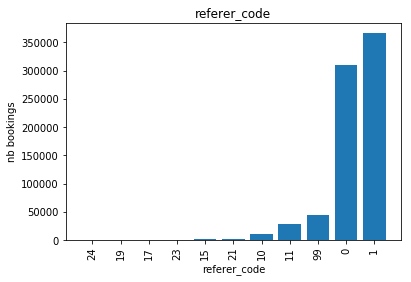


referer code, number of bookings
24, 0
19, 0
17, 21
23, 402
15, 1297
21, 1785
10, 10611
11, 29141
99, 43789
0, 309364
1, 366608


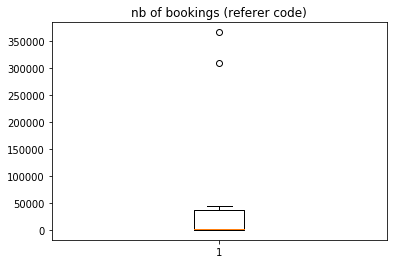

In [100]:
# referer_code: Encoded category of the referer to the website

# dict_referer_code, referer_code_list = get_nb_bookings_dict(train_user_df, 'referer_code')
dict_referer_code_nb_bookings = read_dict_from_csv('referer_code-nb_bookings.csv')
    
dict_referer_code_nb_bookings = OrderedDict(sorted(dict_referer_code_nb_bookings.items(), key=lambda x: x[1]))

plot_dict(dict_referer_code_nb_bookings, 'referer_code', 'referer_code', 'nb bookings')

#plot_dict(dict_feature_nb_bookings['referer_code'], 'referer_code', 'referer_code', 'nb bookings')

print('\nreferer code, number of bookings')
for key, value in dict_referer_code_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plt.boxplot(list(dict_referer_code_nb_bookings.values()))
plt.title('nb of bookings (referer code)')
plt.show()
    
# Users with the referer code 1 have the largest number of bookings
# Users with the referer code 24, 21 have no bookings.

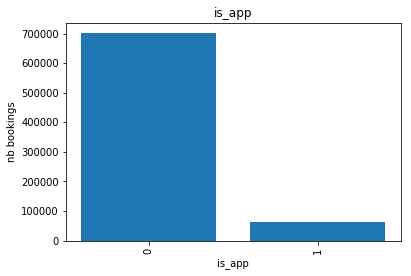


is app, number of bookings
0, 700728
1, 62290


In [101]:
# is_app: If the session was made using the trivago app

dict_is_app_nb_bookings = read_dict_from_csv('is_app-nb_bookings.csv')

plot_dict(dict_is_app_nb_bookings, 'is_app', 'is_app', 'nb bookings')
#plot_dict(dict_feature_nb_bookings['is_app'], 'is_app', 'is_app', 'nb bookings')

print('\nis app, number of bookings')
for key, value in dict_is_app_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
# Most of the bookings were not made using the trivago app.


agent id, number of bookings
4, 0
5, 0
3, 8
12, 712
11, 1355
0, 2848
13, 22603
2, 33837
14, 41526
6, 57113
7, 69730
10, 78506
8, 100915
9, 128797
1, 225068


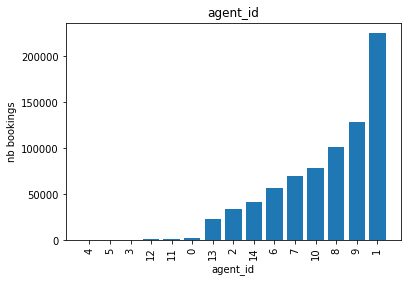

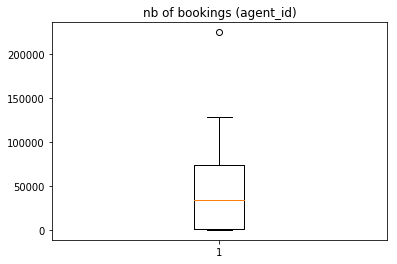

In [102]:
# agent_id: Encoded type of the browser

dict_agend_id_nb_bookings = read_dict_from_csv('agent_id-nb_bookings.csv')
    
dict_agend_id_nb_bookings = OrderedDict(sorted(dict_agend_id_nb_bookings.items(), key=lambda x: x[1]))

print('\nagent id, number of bookings')
for key, value in dict_agend_id_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plot_dict(dict_agend_id_nb_bookings, 'agent_id', 'agent_id', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['agent_id'], 'agent_id', 'agent_id', 'nb bookings')

plt.boxplot(list(dict_agend_id_nb_bookings.values()))
plt.title('nb of bookings (agent_id)')
plt.show()

# We can see that agent_id has the largest number of bookings

traffic type, number of bookings
7, 56
10, 404
4, 4504
6, 35121
3, 42193
2, 172942
1, 507798


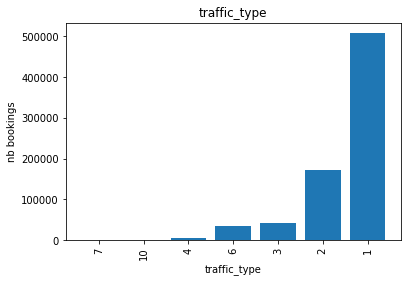

max number of bookings (traffic type): 507798
min number of bookings (traffic type): 56
mean number of bookings (traffic type): 109002.57142857143
standar deviation number of bookings (traffic type): 172225.35335994867


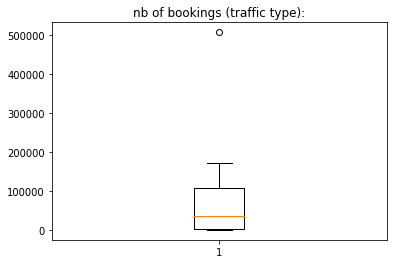

In [103]:
# traffic_type: A categorization of the type of the traffic

dict_traffic_type_nb_bookings = read_dict_from_csv('traffic_type-nb_bookings.csv')
    
dict_traffic_type_nb_bookings = OrderedDict(sorted(dict_traffic_type_nb_bookings.items(), key=lambda x: x[1]))

print('traffic type, number of bookings')
for key, value in dict_traffic_type_nb_bookings.items():
    print('{}, {}'.format(key, value))
    
plot_dict(dict_traffic_type_nb_bookings, 'traffic_type', 'traffic_type', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['traffic_type'], 'traffic_type', 'traffic_type', 'nb bookings')

print('max number of bookings (traffic type): {}'.format(np.max(list(dict_traffic_type_nb_bookings.values()))))
print('min number of bookings (traffic type): {}'.format(np.min(list(dict_traffic_type_nb_bookings.values()))))
print('mean number of bookings (traffic type): {}'.format(np.mean(list(dict_traffic_type_nb_bookings.values()))))
print('standar deviation number of bookings (traffic type): {}'.format(np.std(list(dict_traffic_type_nb_bookings.values()))))

plt.boxplot(list(dict_traffic_type_nb_bookings.values()))
plt.title('nb of bookings (traffic type):')
plt.show()

# We can see the first category of traffic type 1 has the largest number of bookings

number of action id 211


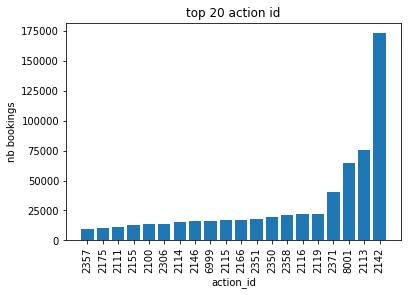

max number of bookings (action id) 173073
min number of bookings (action id) 0
mean number of bookings (action id) 3616.1990521327016
standar deviation number of bookings (action id) 14372.75768847971


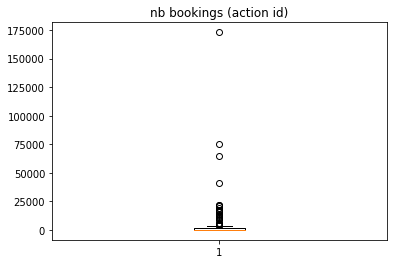

In [104]:
# action_id: Type of the action

dict_action_id_nb_bookings = read_dict_from_csv('action_id-nb_bookings.csv')
    
dict_action_id_nb_bookings = OrderedDict(sorted(dict_action_id_nb_bookings.items(), key=lambda x: x[1]))

print('number of action id {}'.format(len(list(dict_action_id_nb_bookings.keys()))))

dict_action_id_nb_bookings_top = {}

key_list = list(dict_action_id_nb_bookings.keys())[-20:]
for key in key_list:
    dict_action_id_nb_bookings_top[key] = dict_action_id_nb_bookings[key]
    
plot_dict(dict_action_id_nb_bookings_top, 'top 20 action id', 'action_id', 'nb bookings')

action_id_nb_booking_list = list(dict_action_id_nb_bookings.values())
print('max number of bookings (action id) {}'.format(np.max(action_id_nb_booking_list)))
print('min number of bookings (action id) {}'.format(np.min(action_id_nb_booking_list)))
print('mean number of bookings (action id) {}'.format(np.mean(action_id_nb_booking_list)))
print('standar deviation number of bookings (action id) {}'.format(np.std(action_id_nb_booking_list)))
#plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

plt.boxplot(action_id_nb_booking_list)
plt.title('nb bookings (action id)')
plt.show()

number of references 121529


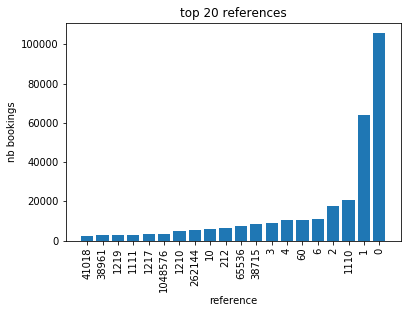

max number of bookings (reference) 105519:
min number of bookings (reference) 2532:
mean number of bookings (reference) 15205.75:
standar deviation number of bookings (reference) 24555.59740033828:


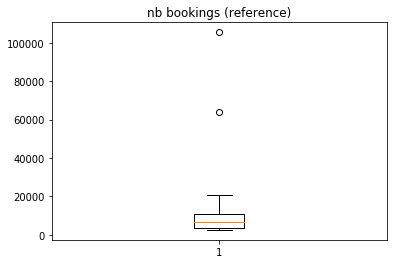

In [105]:
# reference: Object of the action. 
# - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to 
# the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
    
dict_reference_nb_bookings = read_dict_from_csv('reference-nb_bookings.csv')
    
dict_reference_nb_bookings = OrderedDict(sorted(dict_reference_nb_bookings.items(), key=lambda x: x[1]))

print('number of references {}'.format(len(list(dict_reference_nb_bookings.keys()))))

dict_reference_nb_bookings_top = {}

key_list = list(dict_reference_nb_bookings.keys())[-20:]
for key in key_list:
    dict_reference_nb_bookings_top[key] = dict_reference_nb_bookings[key]
    
plot_dict(dict_reference_nb_bookings_top, 'top 20 references', 'reference', 'nb bookings')

reference_nb_booking_list = list(dict_reference_nb_bookings_top.values())
print('max number of bookings (reference) {}:'.format(np.max(reference_nb_booking_list)))
print('min number of bookings (reference) {}:'.format(np.min(reference_nb_booking_list)))
print('mean number of bookings (reference) {}:'.format(np.mean(reference_nb_booking_list)))
print('standar deviation number of bookings (reference) {}:'.format(np.std(reference_nb_booking_list)))
#plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

plt.boxplot(reference_nb_booking_list)
plt.title('nb bookings (reference)')
plt.show()

# plot_dict(dict_feature_nb_bookings['reference'], 'reference', 'reference', 'nb bookings')


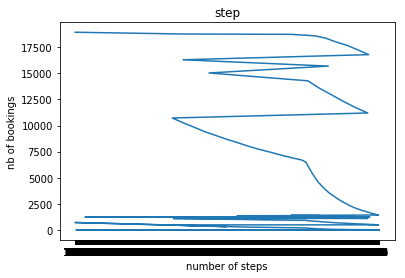

max number of bookings (step) 18936
min number of bookings (step) 0
mean number of bookings (step) 243.46458200382898
standar deviation number of bookings (step) 1417.644272898756


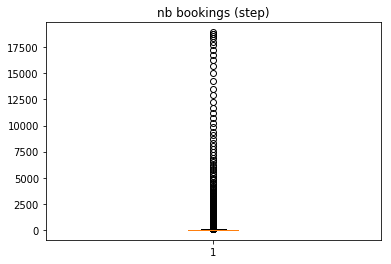

In [106]:
# step: The number identifying the action in the session
    
# print(target_user_df['step'].unique())

dict_step_nb_bookings = read_dict_from_csv('step-nb_bookings.csv')

plt.plot(list(dict_step_nb_bookings.keys()), list(dict_step_nb_bookings.values()))
plt.title('step')
plt.xlabel('number of steps')
plt.ylabel('nb of bookings')
plt.show()
# plot_dict(dict_step_nb_bookings, 'step', 'number of step', 'nb bookings')

# plot_dict(dict_feature_nb_bookings['step'], 'step', 'step', 'nb bookings')

step_nb_booking_list = list(dict_step_nb_bookings.values())
print('max number of bookings (step) {}'.format(np.max(step_nb_booking_list)))
print('min number of bookings (step) {}'.format(np.min(step_nb_booking_list)))
print('mean number of bookings (step) {}'.format(np.mean(step_nb_booking_list)))
print('standar deviation number of bookings (step) {}'.format(np.std(step_nb_booking_list)))

plt.boxplot(step_nb_booking_list)
plt.title('nb bookings (step)')
plt.show()

# It shows more steps less number of bookings.

## Step 2: Train machine learning models


### First approach

First, I use all the features of the current steps, i.e., 
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']. 

Note: although I find that 8062/23402 users in the target set can be found in the train set, I doubt taking 'user_id' as features overfits the model. Therefore, user_id is not used to train the model.

In [1]:
# define the machine learning model

def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
def train_xgb(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=4, folds=3, 
              param_comb=5, n_estimators=100):
    """
    train a xgb model

    Reference
    https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    """
    # xgb_clf = XGBClassifier(learning_rate=0.01,
    #                     n_estimators=200,
    #                     objective='binary:logistic',
    #                     silent=True, nthread=nthread)

    print('\n === train a xgb model === \n')

    xgb_clf = XGBClassifier(n_estimators=n_estimators, nthread=n_jobs, objective='binary:logistic', silent=True,)

    if hyperparameter_tuning:
        print('xgb hyperparameter tuning ...')

        params = {
            'n_estimators': [5, 10, 80, 100, 200],
            'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            'gamma': [0.5, 1, 1.5, 2],
            # 'subsample': [0.6, 0.8, 1.0],
            'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

        random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                           n_jobs=n_jobs,
                                           cv=skf.split(X_train, Y_train),
                                           verbose=3, random_state=42)

        start_time = timer(None)
        random_search.fit(X_train, Y_train)
        timer(start_time)

        print('--------------')
        print('\n all results:')
        print(random_search.cv_results_)

        print('\n best estimator:')
        print(random_search.best_estimator_)

        print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)

        print('\n best xgb hyperparameters:')
        print(random_search.best_params_)

        result_csv_path = 'xgb-random-grid-search-results.csv'
        results = pd.DataFrame(random_search.cv_results_)
        results.to_csv(result_csv_path, index=False)
        print('save xgb random search results to {}'.format(result_csv_path))
        print('--------------')

        #xgb_clf = random_search
        xgb_clf = random_search.best_estimator_
    else:
        xgb_clf.fit(train_sub_x, train_sub_y)

    if model_path is None:
        xgb_model_path = 'xgb.model'
        if hyperparameter_tuning:
            xgb_model_path = 'xgb.ht.model'
    else:
        xgb_model_path = model_path
        # xgb_clf.save_model(xgb_model_path)
    joblib.dump(xgb_clf, xgb_model_path)
    print('\n save the xgb model to {}'.format(xgb_model_path))

    return xgb_clf, xgb_model_path


def train_rf(X_train, Y_train, hyperparameter_tuning=False, model_path=None, n_jobs=4, folds=3, n_estimators=100):
    """
    train a RF classifier

    Reference
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    """
    print('\n === train a random forest model === \n')

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=n_jobs)

    if hyperparameter_tuning:
        # Number of trees in random forest
        #n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
        n_estimators = [5, 10, 80, 100, 200]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        #max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth = [4, 6, 8]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        #print(random_grid)

        rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        rf_random.fit(X_train, X_train)

        print('--------------')
        print('\n all results:')
        print(rf_random.cv_results_)

        print('\n best estimator:')
        print(rf_random.best_estimator_)

        print('\n best rf parameters:')
        print(rf_random.best_params_)

        print('\n best scores:')
        rf_random.best_score_

        result_cv_path = 'rf-random-grid-search-results.csv'
        results = pd.DataFrame(rf_random.cv_results_)
        results.to_csv(result_cv_path, index=False)
        print('\n save rf random search results to {}'.format(result_cv_path))
        print('--------------')

        model = rf_random.best_estimator_
    else:
        model.fit(X_train, Y_train)

    if model_path is None:
        model_path = 'rf.model'
        if hyperparameter_tuning:
            model_path = 'rf.ht.model'

    joblib.dump(model, model_path)
    print('\n save the rf model to {}'.format(model_path))

    return model, model_path


def train_nb(X_train, Y_train, model_path=None):
    """
    train a naive bayes classifier
    """
    # reference https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

    print('\n === train a gaussian naive bayes model === \n')

    model = GaussianNB()
    model.fit(X_train, Y_train,)

    if model_path is None:
        model_path = 'nb.model'

    joblib.dump(model, model_path)
    print('\n save the GaussianNB model to {}'.format(model_path))

    return model, model_path


def train_lgbm(X_train, Y_train,
               categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
               model_path=None, n_jobs=4, hyperparameter_tuning=False, num_boost_round=100, folds=3):
    """
    train a lightGBM model

    Reference
    https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
    https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823?scriptVersionId=1751960
    """

    print('\n === train a lightGBM === \n')

    d_train = lgb.Dataset(X_train, label=Y_train,
                          # categorical_feature=['aisle_id', 'department_id']
                          categorical_feature=categorical_feature,
                          )

    if not hyperparameter_tuning:
        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'num_class': 1,                # must be 1 for non-multiclass training
            'metric': 'binary_error',
            #'metric': 'binary_logloss',
            #'n_jobs': n_jobs,
            'nthread': n_jobs,
            'num_leaves': 31,
            #'num_leaves': 64,
            'min_child_weight': 1,
            'min_child_samples': 5,
            'scale_pos_weight': 1,
            'reg_alpha': 5,
            'learning_rate': 0.05,
            'max_bin': 512,
            #'feature_fraction': 0.9,
            #'bagging_fraction': 0.8,
            #'bagging_freq': 5,
            #'verbose': 0
        }

        gbm = lgb.train(params,
                        d_train,
                        num_boost_round=num_boost_round,
                        categorical_feature=categorical_feature)

    else:
        params = {'boosting_type': 'gbdt',
                  'max_depth': -1,
                  'objective': 'binary',
                  'nthread': n_jobs,  # Updated from nthread
                  'num_leaves': 64,
                  'learning_rate': 0.05,
                  'max_bin': 512,
                  'subsample_for_bin': 200,
                  'subsample': 1,
                  'subsample_freq': 1,
                  'colsample_bytree': 0.8,
                  'reg_alpha': 5,
                  'reg_lambda': 10,
                  'min_split_gain': 0.5,
                  'min_child_weight': 1,
                  'min_child_samples': 5,
                  'scale_pos_weight': 1,
                  'num_class': 1,
                  'metric': 'binary_error'}

        gridParams = {
            'learning_rate': [0.005],
            'n_estimators': [8, 16, 24],
            'num_leaves': [6, 8, 12, 16],
            'boosting_type': ['gbdt'],
            'objective': ['binary'],
            'random_state': [42],  # Updated from 'seed'
            'colsample_bytree': [0.64, 0.65, 0.66],
            'subsample': [0.7, 0.75],
            'reg_alpha': [1, 1.2],
            'reg_lambda': [1, 1.2, 1.4],
        }

        mdl = lgb.LGBMClassifier(boosting_type='gbdt',
                                 objective='binary',
                                 n_jobs=n_jobs,  # Updated from 'nthread'
                                 silent=True,
                                 max_depth=params['max_depth'],
                                 max_bin=params['max_bin'],
                                 subsample_for_bin=params['subsample_for_bin'],
                                 subsample=params['subsample'],
                                 subsample_freq=params['subsample_freq'],
                                 min_split_gain=params['min_split_gain'],
                                 min_child_weight=params['min_child_weight'],
                                 min_child_samples=params['min_child_samples'],
                                 scale_pos_weight=params['scale_pos_weight'])

        print(mdl.get_params().keys())

        grid = RandomizedSearchCV(estimator=mdl, param_distributions=gridParams,
                                       n_iter=100, cv=folds, verbose=2, random_state=42, n_jobs=n_jobs)

        #grid = GridSearchCV(mdl, gridParams, verbose=2, cv=folds, n_jobs=n_jobs)
        grid.fit(X_train, Y_train)

        print('best parameters:')
        print(grid.best_params_)
        print('best score: ')
        print(grid.best_score_)

        # using parameters already set above, replace in the best from the grid search
        params['colsample_bytree'] = grid.best_params_['colsample_bytree']
        params['learning_rate'] = grid.best_params_['learning_rate']
        #params['max_bin'] = grid.best_params_['max_bin']
        params['num_leaves'] = grid.best_params_['num_leaves']
        params['reg_alpha'] = grid.best_params_['reg_alpha']
        params['reg_lambda'] = grid.best_params_['reg_lambda']
        params['subsample'] = grid.best_params_['subsample']
        #params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

        print('Fitting with params: ')
        print(params)

        X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

        d_train_sub = lgb.Dataset(X_train_sub, label=Y_train_sub,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        d_val_sub = lgb.Dataset(X_val, label=Y_val,
                              # categorical_feature=['aisle_id', 'department_id']
                              categorical_feature=categorical_feature,
                              #categorical_feature='auto'
                              )

        gbm = lgb.train(params,
                        d_train_sub,
                        num_boost_round=1000,
                        valid_sets=[d_train_sub, d_val_sub],
                        early_stopping_rounds=50,
                        verbose_eval=4)

        # Plot importance
        #lgb.plot_importance(gbm)

    if model_path is None:
        model_path = 'lgbm.model'
        if hyperparameter_tuning:
            model_path = 'lgbm.ht.model'

    # save model to file
    gbm.save_model(model_path)
    print('\n save the lightGBM model to {}'.format(model_path))
    
    gc.collect()

    # load model to predict
    # print('Load model to predict')
    # bst = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # y_pred = bst.predict(X_test)

    return gbm, model_path


def train_catboost(X_train, Y_train,
                   categorical_feature=[0, 1, 2, 3, 4, 5],
                   #categorical_feature=['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference'],
                   model_path=None, hyperparameter_tuning=False, num_boost_round=100):
    """
    train a catboost model

    Reference:
    https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/
    """

    print('\n === train a catboost === \n')

    model = CatBoostClassifier(loss_function='Logloss',
                               iterations=num_boost_round,
                               #learning_rate=1,
                               #depth=2
                               )
    model.fit(X_train, Y_train, categorical_feature)

    if model_path is None:
        model_path = 'catboost.model'
        if hyperparameter_tuning:
            model_path = 'catboost.ht.model'

    model.save_model(model_path)

    print('\n save the catboost model to {}'.format(model_path))

    return model, model_path


def predict(model_path, X_test, is_lgbm=False, is_catboost=False, lgbm_threshold=0.5):
    """
    load the model and predict unseen data
    """

    print('\n === predict === \n')

    if is_lgbm:
        # lightgbm
        model = lgb.Booster(model_file=model_path)
    elif is_catboost:
        model = CatBoostClassifier()
        model = model.load_model(model_path)
    else:
        # sklearn
        # xgboost
        model = joblib.load(model_path)

    # y_pred = model.predict_prob(X_test)
    y_pred = model.predict(X_test)

    if is_lgbm:
        #print('==')
        #print(y_pred)
        y_output = []
        for y in y_pred:
            if y > lgbm_threshold:
                y_output.append(1)
            else:
                y_output.append(0)
        #print('==')
        #print(y_output)
        return(np.array(y_output))
        #return np.array([np.argmax(y) for y in y_pred])
    else:
        return y_pred

In [2]:
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column   = ['has_booking']

# define the data preparation functions

def preprocessing(df):
    print('\n === preprocess data === \n')

    df['action_id'].fillna(NA_ACTION_ID, inplace=True)
    df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
    df['step'].fillna(NA_STEP, inplace=True)

    df['referer_code'] = df['referer_code'].astype('int')
    df['is_app'] = df['is_app'].astype('int')
    df['agent_id'] = df['agent_id'].astype('int')
    df['traffic_type'] = df['traffic_type'].astype('int')
    df['action_id'] = df['action_id'].astype('int')
    df['reference'] = df['reference'].astype('int')
    df['step'] = df['step'].astype('int')

    if 'has_booking' in df.columns:
        df['has_booking'] = df['has_booking'].astype('int')

    return df

def get_train_set(df, feature_columns):
    print('\n === get train set === \n')

    train_df = df[feature_columns + target_column]

    train_x = train_df[feature_columns]
    train_y = train_df[target_column].values

    # https://stackoverflow.com/questions/31995175/scikit-learn-cross-val-score-too-many-indices-for-array
    """
    When we do cross validation in scikit-learn, the process requires an (R,) shape label instead of (R,1). 
    Although they are the same thing to some extend, their indexing mechanisms are different. So in your case, just add:
    c, r = labels.shape
    labels = labels.reshape(c,)
    """
    c, r = train_y.shape
    train_y = train_y.reshape(c, )

    return train_x, train_y

def get_test_set(df, feature_columns):
    print('\n === get test set === \n')

    test_x = df[feature_columns]

    return test_x

In [3]:
# define the evaluation function

def evaluate(y_true, y_pred):
    """
    evaluate the predictions
    """
    print('\n === evaluate === \n')

    nb_bookings_true = 0
    for y in y_true:
        if y == 1:
            nb_bookings_true += 1
    print('\n number of bookings in y_true: {}'.format(nb_bookings_true))
    print('\n y_true shape:')
    print(y_true.shape)

    nb_bookings_pred = 0
    for y in y_pred:
        if y == 1:
            nb_bookings_pred += 1
    print('\n number of bookings in y_pred {}'.format(nb_bookings_pred))
    print('\n y_pred shape:')
    print(y_pred.shape)

    mcc_score = matthews_corrcoef(y_true, y_pred)
    print('\n matthews corrcoef score {}'.format(mcc_score))

    """
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      print(tn)
      print(fp)
      print(fn)
      print(tp)
      print('---')

      mcc = (tp*tn - fp*fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
      print(mcc)
      print(matthews_corrcoef(y_true, y_pred))
      """

    accuracy = accuracy_score(y_true, y_pred)
    print('\n accuracy: {}'.format(accuracy))
    print('\n classification report:')
    print(classification_report(y_true, y_pred))

    f1score = f1_score(y_true, y_pred, average='binary')
    print('\n f1 score: {}'.format(f1score))

    #roc_auc_score(y_true, y_pred)

    return mcc_score, accuracy, f1score

In [ ]:
# prepare data set and save it
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

# replace the NAN values by a specific value
NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

# -------------------
# read the data
train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

train_user_df = pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')
train_user_df = preprocessing(train_user_df)


target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

target_user_df = pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')
target_user_df = preprocessing(target_user_df)

# save the data
train_user_df.to_csv('train_user_df.csv')
target_user_df.to_csv('target_user_df.csv')

In [21]:
train_user_df = pd.read_csv('train_user_df.csv')
target_user_df = pd.read_csv('target_user_df.csv')

feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column   = ['has_booking']

# -------------------
# prepare train, validation, and test sets

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print('\n -----')
print('sub train set size:')
print(train_sub_x.shape)
print(train_sub_y.shape)

print('\n -----')
print('validation set size:')
print(val_x.shape)
print(val_y.shape)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)
# print(test_y.shape)



 === get train set === 


 -----
train set size:
(5864434, 7)
(5864434,)

 -----
sub train set size:
(4691547, 7)
(4691547,)

 -----
validation set size:
(1172887, 7)
(1172887,)

 === get test set === 


 -----
test set size:
(575323, 7)


In [7]:
def plot_performance(x_list, y_list, title, x_label, y_label):
    """
    define the plotting function
    """
    plt.plot(x_list, y_list)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [8]:
approach = 1   # first approach
hyperparameter_tuning = False

=== catboost experiments ===

num_boost_round: 10

 === train a catboost === 

0:	learn: 0.6696084	total: 16.4s	remaining: 2m 27s
1:	learn: 0.6477745	total: 30.2s	remaining: 2m
2:	learn: 0.6273872	total: 45.6s	remaining: 1m 46s
3:	learn: 0.6079511	total: 59s	remaining: 1m 28s
4:	learn: 0.5901802	total: 1m 10s	remaining: 1m 10s
5:	learn: 0.5737348	total: 1m 21s	remaining: 54.6s
6:	learn: 0.5583206	total: 1m 35s	remaining: 40.8s
7:	learn: 0.5440784	total: 1m 46s	remaining: 26.6s
8:	learn: 0.5311601	total: 1m 57s	remaining: 13.1s
9:	learn: 0.5192196	total: 2m 9s	remaining: 0us

 save the catboost model to catboost-[approach]1-[num_boost_round]10-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 1033

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.06452964173276594

 accuracy: 0.8710165599925653

 classification report:
             precision    recall  f1-score   support

       

70:	learn: 0.2839374	total: 12m 6s	remaining: 4m 56s
71:	learn: 0.2831936	total: 12m 16s	remaining: 4m 46s
72:	learn: 0.2826649	total: 12m 27s	remaining: 4m 36s
73:	learn: 0.2815416	total: 12m 36s	remaining: 4m 25s
74:	learn: 0.2809722	total: 12m 45s	remaining: 4m 15s
75:	learn: 0.2804404	total: 12m 54s	remaining: 4m 4s
76:	learn: 0.2800170	total: 13m 4s	remaining: 3m 54s
77:	learn: 0.2793937	total: 13m 14s	remaining: 3m 44s
78:	learn: 0.2789435	total: 13m 23s	remaining: 3m 33s
79:	learn: 0.2785208	total: 13m 32s	remaining: 3m 23s
80:	learn: 0.2780878	total: 13m 43s	remaining: 3m 13s
81:	learn: 0.2776685	total: 13m 55s	remaining: 3m 3s
82:	learn: 0.2773517	total: 14m 5s	remaining: 2m 53s
83:	learn: 0.2769956	total: 14m 16s	remaining: 2m 43s
84:	learn: 0.2766912	total: 14m 30s	remaining: 2m 33s
85:	learn: 0.2763218	total: 14m 43s	remaining: 2m 23s
86:	learn: 0.2757530	total: 14m 56s	remaining: 2m 13s
87:	learn: 0.2754782	total: 15m 9s	remaining: 2m 4s
88:	learn: 0.2752450	total: 15m 20s

111:	learn: 0.2690120	total: 20m 1s	remaining: 6m 47s
112:	learn: 0.2688046	total: 20m 13s	remaining: 6m 37s
113:	learn: 0.2685826	total: 20m 28s	remaining: 6m 27s
114:	learn: 0.2682050	total: 20m 44s	remaining: 6m 18s
115:	learn: 0.2679539	total: 20m 58s	remaining: 6m 8s
116:	learn: 0.2678109	total: 21m 12s	remaining: 5m 58s
117:	learn: 0.2676780	total: 21m 26s	remaining: 5m 48s
118:	learn: 0.2675188	total: 21m 40s	remaining: 5m 38s
119:	learn: 0.2673407	total: 21m 52s	remaining: 5m 28s
120:	learn: 0.2670886	total: 22m 8s	remaining: 5m 18s
121:	learn: 0.2669146	total: 22m 21s	remaining: 5m 7s
122:	learn: 0.2666389	total: 22m 34s	remaining: 4m 57s
123:	learn: 0.2663414	total: 22m 49s	remaining: 4m 47s
124:	learn: 0.2661856	total: 22m 58s	remaining: 4m 35s
125:	learn: 0.2658597	total: 23m 11s	remaining: 4m 25s
126:	learn: 0.2656873	total: 23m 24s	remaining: 4m 14s
127:	learn: 0.2655129	total: 23m 37s	remaining: 4m 3s
128:	learn: 0.2653311	total: 23m 51s	remaining: 3m 53s
129:	learn: 0.2

101:	learn: 0.2713874	total: 17m 24s	remaining: 16m 43s
102:	learn: 0.2711457	total: 17m 35s	remaining: 16m 34s
103:	learn: 0.2707656	total: 17m 46s	remaining: 16m 24s
104:	learn: 0.2705790	total: 17m 59s	remaining: 16m 16s
105:	learn: 0.2703775	total: 18m 8s	remaining: 16m 5s
106:	learn: 0.2703192	total: 18m 19s	remaining: 15m 55s
107:	learn: 0.2698157	total: 18m 28s	remaining: 15m 44s
108:	learn: 0.2693362	total: 18m 38s	remaining: 15m 33s
109:	learn: 0.2691562	total: 18m 52s	remaining: 15m 26s
110:	learn: 0.2688154	total: 19m 2s	remaining: 15m 16s
111:	learn: 0.2686554	total: 19m 17s	remaining: 15m 9s
112:	learn: 0.2683801	total: 19m 30s	remaining: 15m 1s
113:	learn: 0.2680833	total: 19m 43s	remaining: 14m 53s
114:	learn: 0.2679751	total: 19m 57s	remaining: 14m 45s
115:	learn: 0.2676787	total: 20m 7s	remaining: 14m 34s
116:	learn: 0.2675502	total: 20m 21s	remaining: 14m 26s
117:	learn: 0.2672961	total: 20m 36s	remaining: 14m 19s
118:	learn: 0.2670604	total: 20m 52s	remaining: 14m 12

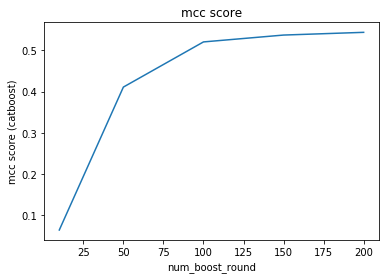

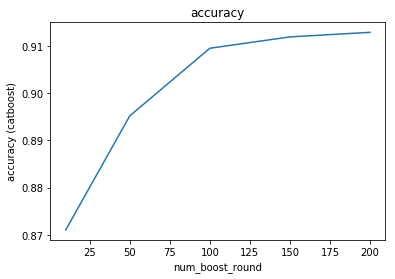

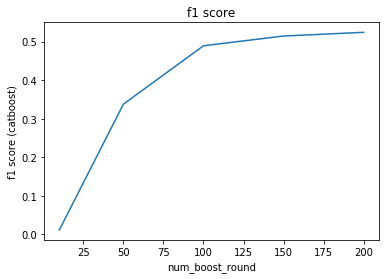

In [9]:
# --------
# catboost performance evaluation on the validation set
#
print('=== catboost experiments ===')

num_boost_round_list = [10, 50, 100, 150, 200] # due to memory issue, I can not increase number of boost round to more than 200.

# key: num_boost_round  value: score
mcc_catboost_list = []
acc_catboost_list = []
f1_catboost_list = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                                 num_boost_round, 
                                                                                 hyperparameter_tuning)
    
    model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_catboost=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_catboost_list.append(mcc_score)
    acc_catboost_list.append(accuracy)
    f1_catboost_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_catboost_list, 'mcc score', 'num_boost_round', 'mcc score (catboost)')
plot_performance(num_boost_round_list, acc_catboost_list, 'accuracy', 'num_boost_round', 'accuracy (catboost)')
plot_performance(num_boost_round_list, f1_catboost_list, 'f1 score', 'num_boost_round', 'f1 score (catboost)')


=== xgboost experiments ===

num_boost_round: 10

 === train a xgb model === 


 save the xgb model to xgb-[approach]1-[num_boost_round]10-[ht]False.model

 === predict === 



/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 0

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.0

 accuracy: 0.8703830803819976

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020861
          1       0.00      0.00      0.00    152026

avg / total       0.76      0.87      0.81   1172887


 f1 score: 0.0

num_boost_round: 50

 === train a xgb model === 


 save the xgb model to xgb-[approach]1-[num_boost_round]50-[ht]False.model

 === predict === 



/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 0

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.0

 accuracy: 0.8703830803819976

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020861
          1       0.00      0.00      0.00    152026

avg / total       0.76      0.87      0.81   1172887


 f1 score: 0.0

num_boost_round: 100

 === train a xgb model === 


 save the xgb model to xgb-[approach]1-[num_boost_round]100-[ht]False.model

 === predict === 



/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 172

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.031382848143744965

 accuracy: 0.8705297270751573

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020861
          1       1.00      0.00      0.00    152026

avg / total       0.89      0.87      0.81   1172887


 f1 score: 0.0022602136690363867

num_boost_round: 150

 === train a xgb model === 


 save the xgb model to xgb-[approach]1-[num_boost_round]150-[ht]False.model

 === predict === 



/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 331

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.040213584803173864

 accuracy: 0.8706277757362815

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020861
          1       0.93      0.00      0.00    152026

avg / total       0.88      0.87      0.81   1172887


 f1 score: 0.004056262593776459

num_boost_round: 200

 === train a xgb model === 


 save the xgb model to xgb-[approach]1-[num_boost_round]200-[ht]False.model

 === predict === 



/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 393

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.04175574087285059

 accuracy: 0.8706482380655596

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020861
          1       0.90      0.00      0.00    152026

avg / total       0.87      0.87      0.81   1172887


 f1 score: 0.004618846731706676


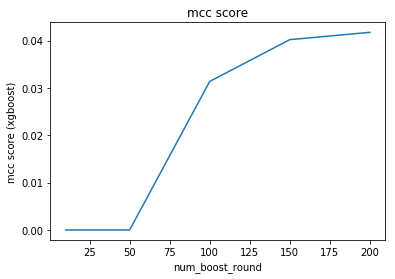

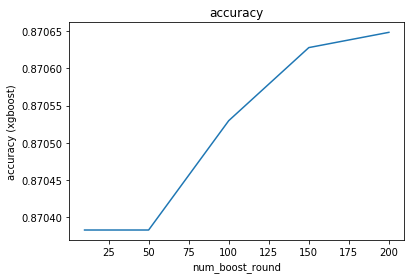

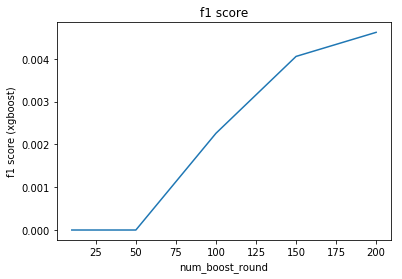

In [11]:
# --------
# xgboost performance evaluation on the validation set
#
print('=== xgboost experiments ===')

num_boost_round_list = [10, 50, 100, 150, 200]

# key: num_boost_round  value: score
mcc_xgb_list = []
acc_xgb_list = []
f1_xgb_list  = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'xgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_xgb(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, n_estimators=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_xgb_list.append(mcc_score)
    acc_xgb_list.append(accuracy)
    f1_xgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_xgb_list, 'mcc score', 'num_boost_round', 'mcc score (xgboost)')
plot_performance(num_boost_round_list, acc_xgb_list, 'accuracy', 'num_boost_round', 'accuracy (xgboost)')
plot_performance(num_boost_round_list, f1_xgb_list, 'f1 score', 'num_boost_round', 'f1 score (xgboost)')

=== lightGBM experiments ===

num_boost_round: 10

 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]10-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 9809

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.2189098172401796

 accuracy: 0.8775798521085152

 classification report:
             precision    recall  f1-score   support

          0       0.88      1.00      0.93   1020861
          1       0.93      0.06      0.11    152026

avg / total       0.88      0.88      0.83   1172887


 f1 score: 0.11276917848425867

num_boost_round: 50

 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]50-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 11219

 y_pred shape:
(1172887,)

 matthews corrcoef 

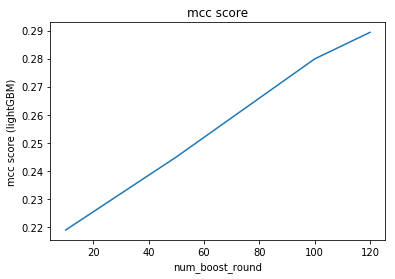

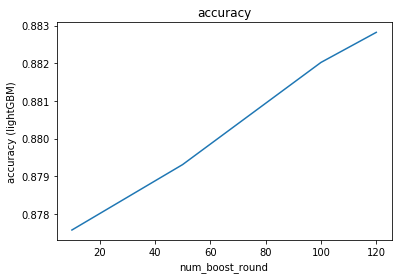

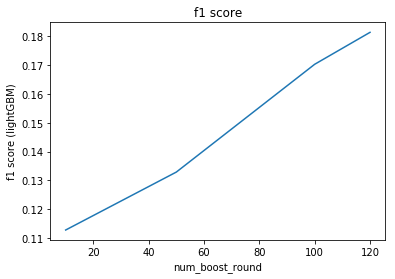

In [8]:
# --------
# lightGBM performance evaluation on the validation set
#
print('=== lightGBM experiments ===')

#num_boost_round_list = [10, 50, 100, 150, 200] # has memory issue
num_boost_round_list = [10, 50, 100, 120]

# key: num_boost_round  value: score
mcc_lgb_list = []
acc_lgb_list = []
f1_lgb_list  = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'lgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_lgbm=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_lgb_list.append(mcc_score)
    acc_lgb_list.append(accuracy)
    f1_lgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_lgb_list, 'mcc score', 'num_boost_round', 'mcc score (lightGBM)')
plot_performance(num_boost_round_list, acc_lgb_list, 'accuracy', 'num_boost_round', 'accuracy (lightGBM)')
plot_performance(num_boost_round_list, f1_lgb_list, 'f1 score', 'num_boost_round', 'f1 score (lightGBM)')

=== lightGBM experiments ===

num_boost_round: 150

 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]150-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 17183

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.29959987650660924

 accuracy: 0.8837117301155184

 classification report:
             precision    recall  f1-score   support

          0       0.88      1.00      0.94   1020861
          1       0.95      0.11      0.19    152026

avg / total       0.89      0.88      0.84   1172887


 f1 score: 0.19393767470997403

num_boost_round: 200

 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]200-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 18567

 y_pred shape:
(1172887,)

 matthews cor

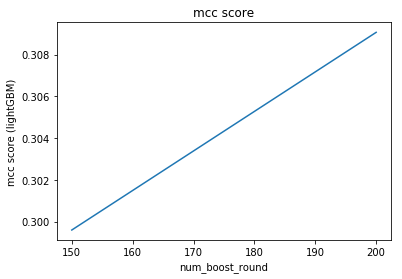

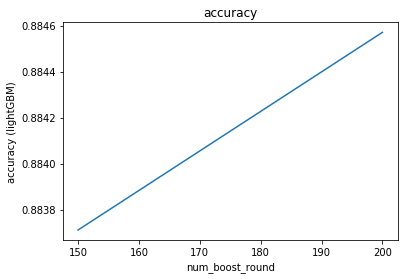

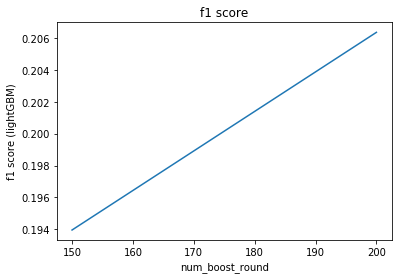

In [9]:
print('=== lightGBM experiments ===')

num_boost_round_list = [150, 200] 

# key: num_boost_round  value: score
mcc_lgb_list = []
acc_lgb_list = []
f1_lgb_list  = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'lgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_lgbm=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_lgb_list.append(mcc_score)
    acc_lgb_list.append(accuracy)
    f1_lgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_lgb_list, 'mcc score', 'num_boost_round', 'mcc score (lightGBM)')
plot_performance(num_boost_round_list, acc_lgb_list, 'accuracy', 'num_boost_round', 'accuracy (lightGBM)')
plot_performance(num_boost_round_list, f1_lgb_list, 'f1 score', 'num_boost_round', 'f1 score (lightGBM)')

In [ ]:
print('=== lightGBM experiments ===')

num_boost_round_list = [250, 270] # memory issue 

# key: num_boost_round  value: score
mcc_lgb_list = []
acc_lgb_list = []
f1_lgb_list  = []

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'lgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(approach, 
                                                                            num_boost_round,
                                                                            hyperparameter_tuning)
    
    model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_lgbm=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_lgb_list.append(mcc_score)
    acc_lgb_list.append(accuracy)
    f1_lgb_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_lgb_list, 'mcc score', 'num_boost_round', 'mcc score (lightGBM)')
plot_performance(num_boost_round_list, acc_lgb_list, 'accuracy', 'num_boost_round', 'accuracy (lightGBM)')
plot_performance(num_boost_round_list, f1_lgb_list, 'f1 score', 'num_boost_round', 'f1 score (lightGBM)')

=== lightGBM experiments ===

num_boost_round: 250

 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]250-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 19752

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.3166592909804971

 accuracy: 0.8852796560964526

 classification report:
             precision    recall  f1-score   support

          0       0.88      1.00      0.94   1020861
          1       0.94      0.12      0.22    152026

avg / total       0.89      0.89      0.84   1172887


 f1 score: 0.21669829663868478

num_boost_round: 270

 === train a lightGBM === 



=== random forest experiments ===

n_estimators: 10

 === train a random forest model === 


 save the rf model to rf-[approach]1-[n_estimators]10-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 75061

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.33700848235804215

 accuracy: 0.878384703726787

 classification report:
             precision    recall  f1-score   support

          0       0.90      0.97      0.93   1020861
          1       0.56      0.28      0.37    152026

avg / total       0.86      0.88      0.86   1172887


 f1 score: 0.3718662891314783

n_estimators: 50

 === train a random forest model === 


 save the rf model to rf-[approach]1-[n_estimators]50-[ht]False.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 78478

 y_pred shape:
(1172887,)

 matthews corrcoef

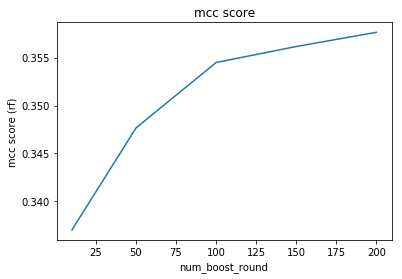

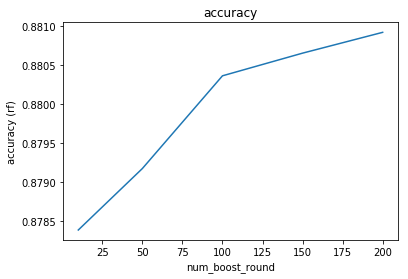

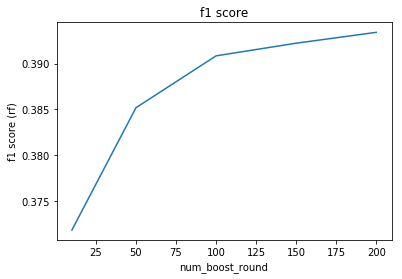

In [9]:
# --------
# random forest performance evaluation on the validation set
#
print('=== random forest experiments ===')

n_estimators_list = [10, 50, 100, 150, 200] # due to memroy issue, I can not increase the number of estimators.

# key: n_estimators  value: score
mcc_rf_list = []
acc_rf_list = []
f1_rf_list  = []

for n_estimators in n_estimators_list:
    print('\nn_estimators: {}'.format(n_estimators))
    
    model_path = 'rf-{}.model'.format(n_estimators)
    
    model_path = 'rf-[approach]{}-[n_estimators]{}-[ht]{}.model'.format(approach,
                                                                        n_estimators,
                                                                        hyperparameter_tuning)
    
    model, model_path = train_rf(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                 model_path=model_path, n_estimators=n_estimators)
    
    y_pred = predict(model_path=model_path, X_test=val_x)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_rf_list.append(mcc_score)
    acc_rf_list.append(accuracy)
    f1_rf_list.append(f1score)
    
plot_performance(n_estimators_list, mcc_rf_list, 'mcc score', 'num_boost_round', 'mcc score (rf)')
plot_performance(n_estimators_list, acc_rf_list, 'accuracy', 'num_boost_round', 'accuracy (rf)')
plot_performance(n_estimators_list, f1_rf_list, 'f1 score', 'num_boost_round', 'f1 score (rf)')

In [10]:
# --------
# naive bayes classifier performance evaluation on the validation set
#
print('=== navie bayes experiments ===')

mcc_nb = 0
acc_nb = 0
f1_nb  = 0

model_path = 'nb.model'
    
model, model_path = train_nb(train_sub_x, train_sub_y, model_path=model_path)
    
y_pred = predict(model_path=model_path, X_test=val_x)
    
mcc_nb, acc_nb, f1_nb = evaluate(val_y, y_pred)
    
print('mcc (nb): {}'.format(mcc_nb))
print('acc (nb): {}'.format(acc_nb))
print('f1 score (nb): {}'.format(f1_nb))

=== navie bayes experiments ===

 === train a gaussian naive bayes model === 


 save the GaussianNB model to nb.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152026

 y_true shape:
(1172887,)

 number of bookings in y_pred 16990

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.04040400967746869

 accuracy: 0.8628955730603204

 classification report:
             precision    recall  f1-score   support

          0       0.87      0.99      0.93   1020861
          1       0.24      0.03      0.05    152026

avg / total       0.79      0.86      0.81   1172887


 f1 score: 0.0485634496142377
mcc (nb): 0.04040400967746869
acc (nb): 0.8628955730603204
f1 score (nb): 0.0485634496142377


In [22]:
# blend all the models (ensemble)

# define the blending function
def blend_predictions(y_pred_list, threshold=0.7):
    """
    blend the predictions
    """
    print('\n === blend predictions === \n')

    y_pred = y_pred_list[0]

    for i in range(1, len(y_pred_list)):
        for j in range(len(y_pred)):
            y_pred[j] += y_pred_list[i][j]

    y_pred = y_pred*1.0 / len(y_pred_list)

    y_output = []
    for y in y_pred:
        if y > threshold:
            y_output.append(1)
        else:
            y_output.append(0)

    return np.array(y_output)


feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
target_column   = ['has_booking']

# read data
train_user_df = pd.read_csv('train_user_df.csv')
target_user_df = pd.read_csv('target_user_df.csv')

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))
    
train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print('\n -----')
print('sub train set size:')
print(train_sub_x.shape)
print(train_sub_y.shape)

print('\n -----')
print('validation set size:')
print(val_x.shape)
print(val_y.shape)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)

# train the models and make prediction
y_pred_list = []

# catboost
model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(1, 200, False)
model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=False, 
                                       model_path=model_path, num_boost_round=200)
y_pred = predict(model_path=model_path, X_test=val_x, is_catboost=True)
y_pred_list.append(y_pred)


#xgb
model_path = 'xgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(1, 200, False) 
model, model_path = train_xgb(train_sub_x, train_sub_y, hyperparameter_tuning=False, 
                                       model_path=model_path, n_estimators=200)
y_pred = predict(model_path=model_path, X_test=val_x)
y_pred_list.append(y_pred)


#lightGBM
model_path = 'lgb-[approach]{}-[num_boost_round]{}-[ht]{}.model'.format(1, 250, False)    
model, model_path = train_lgbm(train_sub_x, train_sub_y, hyperparameter_tuning=False, 
                                   model_path=model_path, num_boost_round=250)
y_pred = predict(model_path=model_path, X_test=val_x, is_lgbm=True)
y_pred_list.append(y_pred)


# blend the predictions
y_pred_blend = blend_predictions(y_pred_list)


# evaluate the blending result
mcc_blend, acc_blend, f1_blend = evaluate(val_y, y_pred_blend)
    
print('mcc (blend): {}'.format(mcc_blend))
print('acc (blend): {}'.format(acc_blend))
print('f1 score (blend): {}'.format(f1_blend))



 === get train set === 


 -----
train set size:
(5864434, 7)
(5864434,)

 -----
sub train set size:
(4691547, 7)
(4691547,)

 -----
validation set size:
(1172887, 7)
(1172887,)

 === get test set === 


 -----
test set size:
(575323, 7)

 === train a catboost === 

0:	learn: 0.6695561	total: 15.1s	remaining: 50m 10s
1:	learn: 0.6477050	total: 26.2s	remaining: 43m 9s
2:	learn: 0.6272556	total: 40.7s	remaining: 44m 30s
3:	learn: 0.6084599	total: 54.1s	remaining: 44m 11s
4:	learn: 0.5903700	total: 1m 9s	remaining: 45m 24s
5:	learn: 0.5738621	total: 1m 17s	remaining: 41m 58s
6:	learn: 0.5583433	total: 1m 26s	remaining: 39m 32s
7:	learn: 0.5443653	total: 1m 34s	remaining: 37m 47s
8:	learn: 0.5311414	total: 1m 41s	remaining: 36m 4s
9:	learn: 0.5192937	total: 1m 53s	remaining: 35m 54s
10:	learn: 0.5081452	total: 2m 4s	remaining: 35m 30s
11:	learn: 0.4978282	total: 2m 13s	remaining: 34m 58s
12:	learn: 0.4882889	total: 2m 24s	remaining: 34m 33s
13:	learn: 0.4790708	total: 2m 34s	remaining: 34

146:	learn: 0.2611131	total: 24m 57s	remaining: 8m 59s
147:	learn: 0.2610409	total: 25m 11s	remaining: 8m 50s
148:	learn: 0.2608999	total: 25m 22s	remaining: 8m 41s
149:	learn: 0.2608223	total: 25m 35s	remaining: 8m 31s
150:	learn: 0.2606916	total: 25m 44s	remaining: 8m 21s
151:	learn: 0.2605999	total: 25m 55s	remaining: 8m 11s
152:	learn: 0.2604749	total: 26m 3s	remaining: 8m
153:	learn: 0.2603747	total: 26m 12s	remaining: 7m 49s
154:	learn: 0.2602730	total: 26m 20s	remaining: 7m 38s
155:	learn: 0.2601165	total: 26m 28s	remaining: 7m 28s
156:	learn: 0.2600415	total: 26m 36s	remaining: 7m 17s
157:	learn: 0.2600184	total: 26m 48s	remaining: 7m 7s
158:	learn: 0.2599631	total: 26m 58s	remaining: 6m 57s
159:	learn: 0.2598899	total: 27m 7s	remaining: 6m 46s
160:	learn: 0.2597568	total: 27m 15s	remaining: 6m 36s
161:	learn: 0.2596554	total: 27m 26s	remaining: 6m 26s
162:	learn: 0.2596326	total: 27m 36s	remaining: 6m 16s
163:	learn: 0.2595544	total: 27m 49s	remaining: 6m 6s
164:	learn: 0.2594

/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 === train a lightGBM === 


 save the lightGBM model to lgb-[approach]1-[num_boost_round]250-[ht]False.model

 === predict === 


 === blend predictions === 


 === evaluate === 


 number of bookings in y_true: 152645

 y_true shape:
(1172887,)

 number of bookings in y_pred 181

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.032118482740062626

 accuracy: 0.8700096428726724

 classification report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93   1020242
          1       1.00      0.00      0.00    152645

avg / total       0.89      0.87      0.81   1172887


 f1 score: 0.002368706895423554
mcc (blend): 0.032118482740062626
acc (blend): 0.8700096428726724
f1 score (blend): 0.002368706895423554


It seems that the blend approach does not improve the performance.


### Second approach: Using historical data

In this approach, the action information (i.e., action_id, reference) of the previous steps is considered as features.
For each session, at each n steps, the m previous steps action information will be considered as features.
n and m are two hyperparameters. With small n (i.e., 1) and large m (i.e., the maximum number of steps in the train set), we will get better performance. However, due to the large amount of sessions (i.e., more than 300k) and the limitation of my current computation resource, I am not able to set n to 1 and m to a very large number. A powerful computer is required for this task.

In [ ]:
# define feature engineering function

class AddPreActions:
    """
    for each session at each step, add its previous steps information
    """
    previous_action_names = ['action_id', 'reference']
    default_action_values = [-10, -10]

    def __init__(self, df, nb_previous_action=2, step_size=100, n_jobs=2):
        self.df = df
        self.nb_previous_action = nb_previous_action
        self.n_jobs = n_jobs
        self.step_size = step_size

    def func_add_previous_action(self, session_id):
        """
        for each session, at each step_size add nb_previous_action previous action information
        """
        current_steps = self.df[self.df['session_id'] == session_id]['step'].tolist()

        # TODO: use groupby
        # for current_step in current_steps:
        for j in range(0, len(current_steps), self.step_size):
            current_step = current_steps[j]

            # add nb_previous_action previous action information
            for i in range(self.nb_previous_action):
                previous_step = current_step - (i + 1)
                previous_df = self.df[(self.df['session_id'] == session_id) & (self.df['step'] == previous_step)]

                if (not previous_df is None) and (not previous_df.empty):
                    for previous_action in self.previous_action_names:
                        col_name = '{}_{}'.format(previous_action, (i + 1))
                        # print('previous')
                        # print(previous_df[previous_action].values)
                        # print('----')
                        self.df.loc[(self.df['session_id'] == session_id) & (self.df['step'] == current_step), col_name] = previous_df[previous_action].values[0]

                    del previous_df
                    gc.collect()

        del current_steps
        gc.collect()
        # print('---')
        # print(session_id)
        # print(self.df[self.df['session_id'] == session_id])

    def add_previous_action(self,  steps = 5000):
        """
        for each session, at each step_size steps, add nb_previous_action previous action information
        """
        print('== add previous action information ==')

        for i in range(self.nb_previous_action):
            for j, previous_action in enumerate(self.previous_action_names):
                new_col_name = '{}_{}'.format(previous_action, (i + 1))
                self.df[new_col_name] = self.default_action_values[j]

        # start_time = time.time()
        session_id_list = self.df['session_id'].unique()

        print('\nnumber of sessions: {}'.format(len(session_id_list)))

        start = 0
        start_time = time.time()
        session_len = len(session_id_list)
        while start < session_len:
            end = start + steps
            if end > session_len:
                end = session_len
            print('start: {} end: {}'.format(start, end))
            with Pool(self.n_jobs) as p:
                p.map(self.func_add_previous_action, session_id_list[start:end])
            start = end

            time_used = time.time() - start_time
            time_needed = (time_used / (end))*(session_len - end)

            print('{}/{}'.format(end, session_len))
            print('time used (mins): {}'.format(round(time_used/60, 2)))
            print('time required (mins): {}'.format(round(time_needed / 60, 2)))

In [ ]:
# generate new features

train_user_df = pd.read_csv('train_user_df.csv')
target_user_df = pd.read_csv('target_user_df.csv')

step_size = 200
nb_previous_action_list = [2]
n_jobs = 2

# ----------
# add previous action information
# for each session, at each step_size add nb_previous_action previous action information
print('step size: {}'.format(step_size))
for nb_previous_action in nb_previous_action_list:
    print('number of previous steps: {}'.format(nb_previous_action))
    # train data
    print('\n{}'.format(nb_previous_action))

    print('\ntrain data')
    addprevAc = AddPreActions(df=train_user_df, nb_previous_action=nb_previous_action, step_size=step_size, n_jobs=n_jobs)
    addprevAc.add_previous_action()
    train_user_df = addprevAc.df

    df_path = 'train_user_df_{}_{}.csv'.format(step_size, nb_previous_action)
    train_user_df.to_csv(df_path, sep='\t')
    print('\nsave train data to {}'.format(df_path))
    print(train_user_df.head(5))

    print('\ntarget data')
    addprevAc = AddPreActions(df=target_user_df, nb_previous_action=nb_previous_action, step_size=step_size, n_jobs=n_jobs)
    addprevAc.add_previous_action()
    target_user_df = addprevAc.df

    df_path = 'target_user_df_{}_{}.csv'.format(step_size, nb_previous_action)
    target_user_df.to_csv(df_path, sep='\t')
    print('\nsave target data to {}'.format(df_path))
    print(target_user_df.head(5))
    

In [19]:
# get new data
print('== prepare data (with historical data) ==')

# for each n steps add its m previous steps information
# n is the step_size and m is the nb_previous_action
step_size = 200         
nb_previous_action = 2  
print('step size: {}'.format(step_size))
print('number of previous steps: {}'.format(nb_previous_action))

train_user_df  = pd.read_csv('train_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')
target_user_df = pd.read_csv('target_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')

print(train_user_df.columns)

no_feature_name_list = ['Unnamed: 0', 'ymd', 'user_id', 'session_id', 'has_booking']
feature_columns = [feature for feature in train_user_df.columns if not feature in no_feature_name_list]
print('feature columns: ')
print(feature_columns)
target_columns = 'has_booking'

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

print('feature columns: ')
print(train_x.columns)

train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print('\n -----')
print('sub train set size:')
print(train_sub_x.shape)
print(train_sub_y.shape)

print('\n -----')
print('validation set size:')
print(val_x.shape)
print(val_y.shape)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)
# print(test_y.shape)


== prepare data (with historical data) ==
step size: 200
number of previous steps: 2
Index(['Unnamed: 0', 'ymd', 'user_id', 'session_id', 'referer_code', 'is_app',
       'agent_id', 'traffic_type', 'has_booking', 'action_id', 'reference',
       'step', 'action_id_1', 'reference_1', 'action_id_2', 'reference_2'],
      dtype='object')
feature columns: 
['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step', 'action_id_1', 'reference_1', 'action_id_2', 'reference_2']

 === get train set === 


 -----
train set size:
(5864434, 11)
(5864434,)
feature columns: 
Index(['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id',
       'reference', 'step', 'action_id_1', 'reference_1', 'action_id_2',
       'reference_2'],
      dtype='object')

 -----
sub train set size:
(4691547, 11)
(4691547,)

 -----
validation set size:
(1172887, 11)
(1172887,)

 === get test set === 


 -----
test set size:
(575323, 11)


=== catboost experiments on new data ===
category feature index list:
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]

num_boost_round: 10

 === train a catboost === 

0:	learn: 0.6695875	total: 14.6s	remaining: 2m 11s
1:	learn: 0.6476719	total: 23.7s	remaining: 1m 34s
2:	learn: 0.6274008	total: 36.2s	remaining: 1m 24s
3:	learn: 0.6079243	total: 48.1s	remaining: 1m 12s
4:	learn: 0.5901246	total: 1m 1s	remaining: 1m 1s
5:	learn: 0.5736573	total: 1m 10s	remaining: 47s
6:	learn: 0.5582581	total: 1m 19s	remaining: 34.2s
7:	learn: 0.5442947	total: 1m 29s	remaining: 22.3s
8:	learn: 0.5312761	total: 1m 40s	remaining: 11.1s
9:	learn: 0.5190098	total: 1m 51s	remaining: 0us

 save the catboost model to catboost-[approach]2-[num_boost_round]10-[ht]False-[step_size]200-[nb_prev]2.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152688

 y_true shape:
(1172887,)

 number of bookings in y_pred 1047

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.06131431920425651

 accuracy: 0.8

68:	learn: 0.2831719	total: 11m 22s	remaining: 5m 6s
69:	learn: 0.2818336	total: 11m 30s	remaining: 4m 56s
70:	learn: 0.2806101	total: 11m 38s	remaining: 4m 45s
71:	learn: 0.2794555	total: 11m 46s	remaining: 4m 34s
72:	learn: 0.2786695	total: 11m 53s	remaining: 4m 23s
73:	learn: 0.2776494	total: 12m 1s	remaining: 4m 13s
74:	learn: 0.2768831	total: 12m 8s	remaining: 4m 2s
75:	learn: 0.2762426	total: 12m 16s	remaining: 3m 52s
76:	learn: 0.2756745	total: 12m 24s	remaining: 3m 42s
77:	learn: 0.2751978	total: 12m 32s	remaining: 3m 32s
78:	learn: 0.2746913	total: 12m 40s	remaining: 3m 22s
79:	learn: 0.2742289	total: 12m 48s	remaining: 3m 12s
80:	learn: 0.2737878	total: 12m 56s	remaining: 3m 2s
81:	learn: 0.2729782	total: 13m 4s	remaining: 2m 52s
82:	learn: 0.2726421	total: 13m 13s	remaining: 2m 42s
83:	learn: 0.2722555	total: 13m 21s	remaining: 2m 32s
84:	learn: 0.2719613	total: 13m 28s	remaining: 2m 22s
85:	learn: 0.2716196	total: 13m 36s	remaining: 2m 12s
86:	learn: 0.2713458	total: 13m 46

108:	learn: 0.2689455	total: 17m 15s	remaining: 6m 29s
109:	learn: 0.2687462	total: 17m 28s	remaining: 6m 21s
110:	learn: 0.2685076	total: 17m 43s	remaining: 6m 13s
111:	learn: 0.2683232	total: 17m 58s	remaining: 6m 5s
112:	learn: 0.2682712	total: 18m 7s	remaining: 5m 55s
113:	learn: 0.2679531	total: 18m 20s	remaining: 5m 47s
114:	learn: 0.2678622	total: 18m 30s	remaining: 5m 37s
115:	learn: 0.2676560	total: 18m 45s	remaining: 5m 29s
116:	learn: 0.2674556	total: 18m 58s	remaining: 5m 21s
117:	learn: 0.2672044	total: 19m 8s	remaining: 5m 11s
118:	learn: 0.2670406	total: 19m 19s	remaining: 5m 1s
119:	learn: 0.2669110	total: 19m 32s	remaining: 4m 53s
120:	learn: 0.2667366	total: 19m 43s	remaining: 4m 43s
121:	learn: 0.2665900	total: 19m 58s	remaining: 4m 35s
122:	learn: 0.2663097	total: 20m 10s	remaining: 4m 25s
123:	learn: 0.2661765	total: 20m 21s	remaining: 4m 16s
124:	learn: 0.2660471	total: 20m 34s	remaining: 4m 6s
125:	learn: 0.2657873	total: 20m 42s	remaining: 3m 56s
126:	learn: 0.2

97:	learn: 0.2715633	total: 15m 49s	remaining: 16m 28s
98:	learn: 0.2711484	total: 15m 58s	remaining: 16m 17s
99:	learn: 0.2709161	total: 16m 9s	remaining: 16m 9s
100:	learn: 0.2707230	total: 16m 22s	remaining: 16m 3s
101:	learn: 0.2705418	total: 16m 36s	remaining: 15m 57s
102:	learn: 0.2703887	total: 16m 50s	remaining: 15m 51s
103:	learn: 0.2702476	total: 17m 5s	remaining: 15m 46s
104:	learn: 0.2700113	total: 17m 22s	remaining: 15m 42s
105:	learn: 0.2695428	total: 17m 32s	remaining: 15m 33s
106:	learn: 0.2692581	total: 17m 48s	remaining: 15m 28s
107:	learn: 0.2691379	total: 18m 2s	remaining: 15m 21s
108:	learn: 0.2687896	total: 18m 17s	remaining: 15m 16s
109:	learn: 0.2686482	total: 18m 28s	remaining: 15m 6s
110:	learn: 0.2684142	total: 18m 41s	remaining: 14m 58s
111:	learn: 0.2682477	total: 18m 55s	remaining: 14m 51s
112:	learn: 0.2681002	total: 19m 9s	remaining: 14m 45s
113:	learn: 0.2678851	total: 19m 24s	remaining: 14m 38s
114:	learn: 0.2675419	total: 19m 38s	remaining: 14m 31s
11

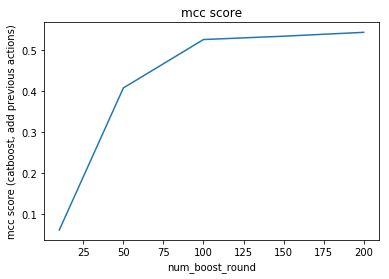

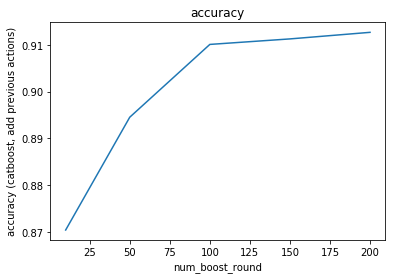

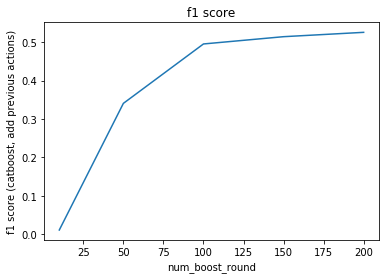

In [20]:
# --------
# catboost performance evaluation on the validation set
#
print('=== catboost experiments on new data ===')

step_size = 200
nb_previous_action = 2
hyperparameter_tuning = False
approach = 2

num_boost_round_list = [10, 50, 100, 150, 200] # due to memory issue, I can not increase number of boost round to more than 200.

# key: num_boost_round  value: score
mcc_catboost_list = []
acc_catboost_list = []
f1_catboost_list  = []

category_feature_index_list = [i for i, feature in enumerate(feature_columns) if feature != 'step']
print('category feature index list:')
print(category_feature_index_list)

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}-[step_size]{}-[nb_prev]{}.model'.format(approach, num_boost_round, 
                                                                                                           hyperparameter_tuning, 
                                                                                                           step_size, 
                                                                                                           nb_previous_action)
    
    model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       categorical_feature=category_feature_index_list,
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_catboost=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_catboost_list.append(mcc_score)
    acc_catboost_list.append(accuracy)
    f1_catboost_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_catboost_list, 'mcc score', 'num_boost_round', 'mcc score (catboost, add previous actions)')
plot_performance(num_boost_round_list, acc_catboost_list, 'accuracy', 'num_boost_round', 'accuracy (catboost, add previous actions)')
plot_performance(num_boost_round_list, f1_catboost_list, 'f1 score', 'num_boost_round', 'f1 score (catboost, add previous actions)')

We can see that the two approaches (i.e., naive approach and using historical data approach) achieved comparable performance. However, in the second approach, the step size (n) is 200 and the number of previous information (m) is 2. The reason why I choose a large n and small m is due to the time issue and limitation of the current computation power. I strongly beleive with a small n and large m, the performance can be improved.

In [27]:
# get new data
print('== prepare data (with historical data) ==')

# for each n steps add its m previous steps information
# n is the step_size and m is the nb_previous_action
step_size = 100         
nb_previous_action = 2  
print('step size: {}'.format(step_size))
print('number of previous steps: {}'.format(nb_previous_action))

train_user_df  = pd.read_csv('train_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')
target_user_df = pd.read_csv('target_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')

print(train_user_df.columns)

no_feature_name_list = ['Unnamed: 0.1', 'Unnamed: 0', 'ymd', 'user_id', 'session_id', 'has_booking']
feature_columns = [feature for feature in train_user_df.columns if not feature in no_feature_name_list]
print('feature columns: ')
print(feature_columns)
target_columns = 'has_booking'

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

print('feature columns: ')
print(train_x.columns)

train_sub_x, val_x, train_sub_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print('\n -----')
print('sub train set size:')
print(train_sub_x.shape)
print(train_sub_y.shape)

print('\n -----')
print('validation set size:')
print(val_x.shape)
print(val_y.shape)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)
# print(test_y.shape)

== prepare data (with historical data) ==
step size: 100
number of previous steps: 2
Index(['Unnamed: 0', 'Unnamed: 0.1', 'ymd', 'user_id', 'session_id',
       'referer_code', 'is_app', 'agent_id', 'traffic_type', 'has_booking',
       'action_id', 'reference', 'step', 'action_id_1', 'reference_1',
       'action_id_2', 'reference_2'],
      dtype='object')
feature columns: 
['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step', 'action_id_1', 'reference_1', 'action_id_2', 'reference_2']

 === get train set === 


 -----
train set size:
(5864434, 11)
(5864434,)
feature columns: 
Index(['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id',
       'reference', 'step', 'action_id_1', 'reference_1', 'action_id_2',
       'reference_2'],
      dtype='object')

 -----
sub train set size:
(4691547, 11)
(4691547,)

 -----
validation set size:
(1172887, 11)
(1172887,)

 === get test set === 


 -----
test set size:
(575323, 11)


In [ ]:
# --------
# catboost performance evaluation on the validation set
#
print('=== catboost experiments on new data ===')

step_size = 100
nb_previous_action = 2
hyperparameter_tuning = False
approach = 2

num_boost_round_list = [10, 50, 100, 150, 200] # due to memory issue, I can not increase number of boost round to more than 200.

# key: num_boost_round  value: score
mcc_catboost_list = []
acc_catboost_list = []
f1_catboost_list  = []

category_feature_index_list = [i for i, feature in enumerate(feature_columns) if feature != 'step']
print('category feature index list:')
print(category_feature_index_list)

for num_boost_round in num_boost_round_list:
    print('\nnum_boost_round: {}'.format(num_boost_round))
    
    model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}-[step_size]{}-[nb_prev]{}.model'.format(approach, num_boost_round, 
                                                                                                           hyperparameter_tuning, 
                                                                                                           step_size, 
                                                                                                           nb_previous_action)
    
    model, model_path = train_catboost(train_sub_x, train_sub_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       categorical_feature=category_feature_index_list,
                                       model_path=model_path, num_boost_round=num_boost_round)
    
    y_pred = predict(model_path=model_path, X_test=val_x, is_catboost=True)
    
    mcc_score, accuracy, f1score = evaluate(val_y, y_pred)
    
    mcc_catboost_list.append(mcc_score)
    acc_catboost_list.append(accuracy)
    f1_catboost_list.append(f1score)
    
plot_performance(num_boost_round_list, mcc_catboost_list, 'mcc score', 'num_boost_round', 'mcc score (catboost, add previous actions)')
plot_performance(num_boost_round_list, acc_catboost_list, 'accuracy', 'num_boost_round', 'accuracy (catboost, add previous actions)')
plot_performance(num_boost_round_list, f1_catboost_list, 'f1 score', 'num_boost_round', 'f1 score (catboost, add previous actions)')

=== catboost experiments on new data ===
category feature index list:
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]

num_boost_round: 10

 === train a catboost === 

0:	learn: 0.6695928	total: 15s	remaining: 2m 15s
1:	learn: 0.6476698	total: 24.6s	remaining: 1m 38s
2:	learn: 0.6273719	total: 34.2s	remaining: 1m 19s
3:	learn: 0.6077426	total: 48.9s	remaining: 1m 13s
4:	learn: 0.5899686	total: 58.8s	remaining: 58.8s
5:	learn: 0.5734984	total: 1m 8s	remaining: 45.5s
6:	learn: 0.5585470	total: 1m 17s	remaining: 33.3s
7:	learn: 0.5442460	total: 1m 31s	remaining: 22.8s
8:	learn: 0.5313169	total: 1m 41s	remaining: 11.3s
9:	learn: 0.5191942	total: 1m 52s	remaining: 0us

 save the catboost model to catboost-[approach]2-[num_boost_round]10-[ht]False-[step_size]100-[nb_prev]2.model

 === predict === 


 === evaluate === 


 number of bookings in y_true: 152442

 y_true shape:
(1172887,)

 number of bookings in y_pred 1088

 y_pred shape:
(1172887,)

 matthews corrcoef score 0.0629295696588564

 accuracy: 0.870

68:	learn: 0.2866411	total: 11m 36s	remaining: 5m 13s
69:	learn: 0.2856236	total: 11m 46s	remaining: 5m 2s
70:	learn: 0.2847152	total: 11m 57s	remaining: 4m 53s
71:	learn: 0.2839067	total: 12m 5s	remaining: 4m 42s
72:	learn: 0.2831106	total: 12m 14s	remaining: 4m 31s
73:	learn: 0.2825731	total: 12m 25s	remaining: 4m 21s
74:	learn: 0.2820550	total: 12m 35s	remaining: 4m 11s
75:	learn: 0.2815554	total: 12m 46s	remaining: 4m 2s
76:	learn: 0.2810207	total: 12m 57s	remaining: 3m 52s
77:	learn: 0.2803905	total: 13m 10s	remaining: 3m 42s
78:	learn: 0.2799005	total: 13m 18s	remaining: 3m 32s
79:	learn: 0.2795093	total: 13m 33s	remaining: 3m 23s
80:	learn: 0.2790241	total: 13m 44s	remaining: 3m 13s
81:	learn: 0.2786656	total: 13m 54s	remaining: 3m 3s
82:	learn: 0.2779340	total: 14m 4s	remaining: 2m 52s
83:	learn: 0.2775873	total: 14m 12s	remaining: 2m 42s
84:	learn: 0.2772628	total: 14m 26s	remaining: 2m 32s
85:	learn: 0.2769070	total: 14m 34s	remaining: 2m 22s
86:	learn: 0.2764894	total: 14m 4

### One-hot-encoding approach

In the data set, all the features are categorical features. Traditional approach is converting the features into one-hot-encoding features. However, the models, Catboost, XGBoost, Randomforest can handle the categorical features automatically quite well. That's why, I didn't try this approach at first. If I have more time I will investigate the one-hot-encoding approach. 

Note we have 211 action id and 121529 references. Therefore, we can not do on-hot-encoding directly on the data. What we can do is first group the data into k categories. As we know that that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.). Some domain knwledge is required.

## Step 3: make predictions on the target data

In [ ]:
def save_prediction(target_user_df, y_pred, file_path):
    """
    save predictions to a csv file
    """
    prediciton_df = pd.DataFrame(columns=['session_id', 'has_booking'])
    prediciton_df['session_id'] = target_user_df['session_id'].values
    prediciton_df['has_booking'] = [int(y) for y in y_pred]

    print('prediction:')
    print(prediciton_df['has_booking'].unique())

    prediciton_df.to_csv(file_path, '\t')
    print('save prediction to {}'.format(file_path))

In [ ]:
# get new data
print('== prepare data (with historical data) ==')

# for each n steps add its m previous steps information
# n is the step_size and m is the nb_previous_action
step_size = 100         
nb_previous_action = 2  
print('step size: {}'.format(step_size))
print('number of previous steps: {}'.format(nb_previous_action))

train_user_df  = pd.read_csv('train_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')
target_user_df = pd.read_csv('target_user_df_{}_{}.csv'.format(step_size, nb_previous_action), sep='\t')

print(train_user_df.columns)

no_feature_name_list = ['Unnamed: 0.1', 'Unnamed: 0', 'ymd', 'user_id', 'session_id', 'has_booking']
feature_columns = [feature for feature in train_user_df.columns if not feature in no_feature_name_list]
print('feature columns: ')
print(feature_columns)
target_columns = 'has_booking'

# shuffle the train set
train_user_df = train_user_df.reindex(np.random.permutation(train_user_df.index))

train_x, train_y = get_train_set(train_user_df, feature_columns)
print('\n -----')
print('train set size:')
print(train_x.shape)
print(train_y.shape)

print('feature columns: ')
print(train_x.columns)

test_x = get_test_set(target_user_df, feature_columns)
print('\n -----')
print('test set size:')
print(test_x.shape)
# print(test_y.shape)

In [ ]:
approach = 2
num_boost_round = 200
step_size = 100
nb_previous_action = 2

category_feature_index_list = [i for i, feature in enumerate(feature_columns) if feature != 'step']
print('category feature index list:')
print(category_feature_index_list)

model_path = 'catboost-[approach]{}-[num_boost_round]{}-[ht]{}-[step_size]{}-[nb_prev]{}-full.model'.format(approach, 
                                                                                                       num_boost_round, 
                                                                                                       hyperparameter_tuning, 
                                                                                                       step_size, 
                                                                                                       nb_previous_action)
    

model, model_path = train_catboost(train_x, train_y, hyperparameter_tuning=hyperparameter_tuning, 
                                       categorical_feature=category_feature_index_list,
                                       model_path=model_path, num_boost_round=num_boost_round)
    
y_pred = predict(model_path=model_path, X_test=test_x, is_catboost=True)

save_prediction(target_user_df, y_pred, 'prediction-catboost-200-100-2.csv')

## Future work

- Hyperparameter tuning with cross validation. Due to the limitation of time and computation power, I didn't try hyperparameter tuning for each of the models. However, the hyperparameter tuning functions have been implemented already.

- Feature engineering, e.g., for each session at each step add m previous steps action information, such that m is the maximum number of steps in the train dataset.

- Deep learning for booking prediction. We could use RNN (or GRU, LSTM) to model the sequences of actions for the sessions.


## Additional questions

#### What makes the classification problem difficult in this task? How do you handle that?
  
  - One difficulty is that we have the categorical features with various values, such as action id, reference.
  One solution is using the tree based models, such as xgboost, catboost, random forest. These model can handle the categorical features automatically. Another solution is using on-hot-encoding approach, by using prior knowledge, we can first group the values into several categories.
  
  - Another difficulty is to predict if a user will book a hotel in the current step is not only affect by the current action but also affected by the previous actions. In other words, for each step, with only the current action information, it's not sufficient enough to predict if the user will book the hotel nor not. Therefore, the previous action information should be included as features. Note due to the limitation of time and computation power, only a part of the experiment results are included in this notebook.

#### Evaluate and compare at least 3 classification methods for this task.
This has been shown previously.
  

#### Propose at least 3 features that are significant to predict bookings?

The historical information of the user is important. For example,
    - The historical booking information
    - The historical searching information (this feature I have used in previous section of this notebook)
    
If a user select a hotel then the features of the hotel is significant to predict bookings. For example:
    - Images
    - Reviews
    - Rating
    - Location
    - Discount
    - Number of users who viewed this hotel
    
The time information could be also helpful. For example, we could convert the dates into several categories. Because we know that during the tourist season, the number of bookings is large.
    
If a user select a hotel, we can provide a button 'Add to list'. In other words, if a user adds some hotels to the list, the likelihood for him to book a hotel will be high. However, I have check several hotel/flight booking engines. None of them have this feature. Therefore, I doubt the effectiveness of this feature.
    
    
    
  
  

#### We can spot a very significant action type. What might this action refer to?

 It has been shown previously that action 2142 has the largest number of bookings, i.e., 173073. This action might refer to click the 'View Deal'
  